# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



# Preprocessing
This part is from assignment 2.

In [81]:
# import
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# - Load the raw data from the file 'alldata.xlsx' into a pandas dataframe.
raw_data = pd.read_excel('alldata.xlsx')

# Utility function - Rename the columns to be more descriptive
def rename_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Renaming the columns for the TV2 answers.
    # So the names are easier to understand and work with.
    tv2_original_columns = ['1a','1b','2a','2b','3a','3b','4a','4b',
                            '5a','5b','6a','6b','7a','7b','8a','8b',
                            '9a','9b','10a','10b','11a','11b','12a','12b']
    tv2_new_columns = ['TV2-1a','TV2-1b','TV2-2a','TV2-2b','TV2-3a','TV2-3b','TV2-4a','TV2-4b',
                       'TV2-5a','TV2-5b','TV2-6a','TV2-6b','TV2-7a','TV2-7b','TV2-8a','TV2-8b',
                       'TV2-9a','TV2-9b','TV2-10a','TV2-10b','TV2-11a','TV2-11b','TV2-12a','TV2-12b']
    
    # ? Renaming the columns for the DR answers.
    # So the names are easier to understand and work with.
    dr_orignal_columns = ['530','531','533','534','535','537','538','540','541','543','544','545','546','547','548',
                          '550','551','552','553','555','556','557','559','561','563']
    
    dr_new_columns =  ['DR-1','DR-2','DR-3','DR-4','DR-5','DR-6','DR-7','DR-8','DR-9','DR-10','DR-11','DR-12','DR-13','DR-14','DR-15',
                       'DR-16','DR-17','DR-18','DR-19','DR-20','DR-21','DR-22','DR-23','DR-24','DR-25']

    other_columns_original = ['navn','alder','parti','storkreds']
    other_columns_new = ['Name','Age','Party','District']

    # ! Renaming the actual columns
    data.rename(columns=dict(zip(tv2_original_columns, tv2_new_columns)), inplace=True)
    data.rename(columns=dict(zip(dr_orignal_columns, dr_new_columns)), inplace=True)
    data.rename(columns=dict(zip(other_columns_original, other_columns_new)), inplace=True)
    
    return data

# Utility function - Set the column order to be more intuitive
def reorder_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Reordering the columns
    # So the columns are easier to understand and work with.
    strict_column_order = ['Name','Age','Party','District'];
    remaining_columns = [col for col in data.columns if col not in strict_column_order]
    data = data[strict_column_order + remaining_columns]
    return data

# * Create a DataFrame
raw_dataFrame = pd.DataFrame(raw_data)

# ! Renaming the columns
clean_dataFrame = rename_columns(raw_dataFrame)

# ! Reordering the columns
clean_dataFrame = reorder_columns(raw_dataFrame)

# ? Cleaning party names
clean_dataFrame['Party'] = clean_dataFrame['Party'].replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Frie Grønne')

# * Preview the cleaned DataFrame
preview_dataFrame = clean_dataFrame.head(5)
preview_dataFrame = preview_dataFrame.style.set_caption('Cleaned DataFrame')

display(preview_dataFrame.hide())

Name,Age,Party,District,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,DR-11,DR-12,DR-13,DR-14,DR-15,DR-16,DR-17,DR-18,DR-19,DR-20,DR-21,DR-22,DR-23,DR-24,DR-25,TV2-1a,TV2-1b,TV2-2a,TV2-2b,TV2-3a,TV2-3b,TV2-4a,TV2-4b,TV2-5a,TV2-5b,TV2-6a,TV2-6b,TV2-7a,TV2-7b,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
Lars Philipsen Prahm,78,Moderaterne,Københavns Storkreds,-1,-2,1,-2,2,1,-2,1,1,2,-2,1,2,2,1,-2,1,2,-2,2,2,1,2,2,-2,0,0,2,2,2,-2,-1,0,-1,1,-1,1,2,2,1,0,2,0,1,-2,-2,1,1,1
Karsten Hønge,64,Socialistisk Folkeparti,Fyns Storkreds,2,2,-1,-2,-1,-2,1,-2,2,-2,2,-1,-2,-2,2,2,-2,1,1,-1,-2,1,2,1,2,1,1,1,1,1,2,2,2,-2,0,1,-2,-2,0,0,0,-2,0,-1,2,1,-2,0,0
Martin Kelleher-Petersen,37,Alternativet,Bornholms Storkreds,2,1,-2,-2,1,-2,1,-1,1,-1,2,-2,-2,-1,1,1,-2,2,-1,-2,-1,1,2,2,2,1,1,1,2,1,1,2,0,-1,1,2,-2,-2,-2,1,1,-1,-2,0,2,0,-1,1,-2
Nicklas Gjedsig Larsen,28,Alternativet,Nordjyllands Storkreds,2,1,-2,-1,1,1,1,1,1,-2,2,1,1,-2,2,2,-2,2,1,2,-2,2,2,2,2,2,2,2,2,0,2,0,2,-2,2,-1,2,0,-2,2,2,-2,2,2,2,2,-1,2,0
Tom Gillesberg,58,Løsgænger,Københavns Storkreds,1,1,-2,2,-2,1,-2,1,2,-2,-2,2,2,-2,2,1,-2,2,-2,-2,-1,1,-2,-1,-2,-2,-2,0,0,-2,-2,2,1,-2,2,1,-2,2,-2,1,0,-2,0,-1,0,-2,0,2,-2


# Analysis

### PCA setup

Here we get the questions form the data set

In [82]:
questions_dataFrame = clean_dataFrame.copy().drop(labels=["Name", "Age", "Party", "District"], axis=1)
display(questions_dataFrame)

,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,...,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
0,-1,-2,1,-2,2,1,-2,1,1,2,...,1,0,2,0,1,-2,-2,1,1,1
1,2,2,-1,-2,-1,-2,1,-2,2,-2,...,0,0,-2,0,-1,2,1,-2,0,0
2,2,1,-2,-2,1,-2,1,-1,1,-1,...,1,1,-1,-2,0,2,0,-1,1,-2
3,2,1,-2,-1,1,1,1,1,1,-2,...,2,2,-2,2,2,2,2,-1,2,0
4,1,1,-2,2,-2,1,-2,1,2,-2,...,1,0,-2,0,-1,0,-2,0,2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,1,1,1,-2,2,-1,1,-2,1,1,...,2,1,1,2,-1,2,1,-2,0,0
863,1,-2,-2,-2,1,-2,-1,-2,-2,-2,...,1,0,-1,0,-1,2,2,-2,0,0
864,1,1,1,-2,2,-1,1,-1,-1,1,...,1,0,-1,0,-1,2,2,-2,0,1
865,1,-1,1,-2,1,-1,-1,-1,-1,1,...,0,0,0,0,0,2,1,-2,1,0


Here we make the PCA

In [83]:
from sklearn.decomposition import PCA
# keep the first ten principal components of the data
pca = PCA(n_components = 10)
# fit PCA model to beast cancer data
pca.fit(questions_dataFrame)

# transform data onto the first ten principal components
X_pca = pca.transform(questions_dataFrame)
print("Original shape: {}".format(str(questions_dataFrame.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

pca.explained_variance_ratio_


Original shape: (867, 49)
Reduced shape: (867, 10)


array([0.45607901, 0.11056386, 0.05043851, 0.03259878, 0.02766934,
       0.02107066, 0.01846724, 0.01536164, 0.01441958, 0.01361333])

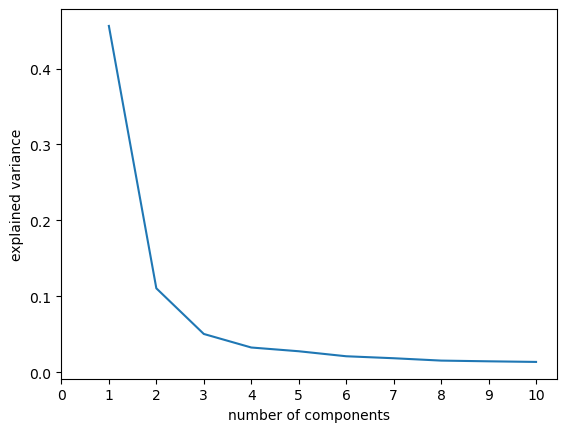

In [84]:
import numpy as np
#Explained variance
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

In [85]:
# keep the first ten principal components of the data
pca = PCA(n_components = 2)
# fit PCA model to beast cancer data
pca.fit(questions_dataFrame)

# transform data onto the first ten principal components
X_pca = pca.transform(questions_dataFrame)
print("Original shape: {}".format(str(questions_dataFrame.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

pca.explained_variance_ratio_


Original shape: (867, 49)
Reduced shape: (867, 2)


array([0.45607901, 0.11056386])

In [87]:
dr_new_columns =  ['DR-1','DR-2','DR-3','DR-4','DR-5','DR-6','DR-7','DR-8','DR-9','DR-10','DR-11','DR-12','DR-13','DR-14','DR-15',
                       'DR-16','DR-17','DR-18','DR-19','DR-20','DR-21','DR-22','DR-23','DR-24','DR-25']

tv2_new_columns = ['TV2-1a','TV2-1b','TV2-2a','TV2-2b','TV2-3a','TV2-3b','TV2-4a','TV2-4b',
                       'TV2-5a','TV2-5b','TV2-6a','TV2-6b','TV2-7a','TV2-7b','TV2-8a','TV2-8b',
                       'TV2-9a','TV2-9b','TV2-10a','TV2-10b','TV2-11a','TV2-11b','TV2-12a','TV2-12b']

feature_names = dr_new_columns + tv2_new_columns

### An analysis/description of which questions are most crucial concerning their placement on the axes.

Text(0, 0.5, 'Principal components')

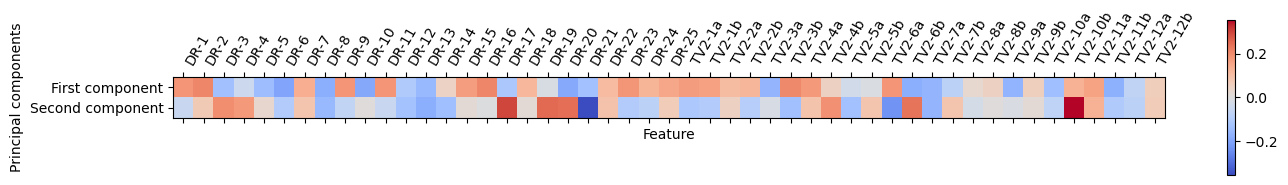

In [96]:
plt.matshow(pca.components_, cmap='coolwarm')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(feature_names)),
           feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

In [89]:
PCA1_abs = [abs(number) for number in pca.components_[0]]

PCA1 = pd.DataFrame({
    'feature_names': feature_names,
    'PCA': pca.components_[0],
    'PCA_abs': PCA1_abs,
})

sorted_df1 = PCA1.sort_values(by='PCA_abs', ascending=False)
sorted_df1.head(6)

,feature_names,PCA,PCA_abs
1,DR-2,0.205416,0.205416
15,DR-16,0.205066,0.205066
30,TV2-3b,0.204075,0.204075
5,DR-6,-0.198883,0.198883
9,DR-10,-0.193057,0.193057
19,DR-20,-0.189554,0.189554


All right here we take the top 6 and look at the questions:
1. DR-2 (531) ARBEJDSMARKED OG ØKONOMI - Der skal indføres en særlig skat på de allerhøjeste indkomster
2. DR-16 (550)  ARBEJDSMARKED OG ØKONOMI - Der skal indføres kvoter, der sikrer mindst 30 procent kvinder i virksomheders bestyrelser
3. TV2-3b Udenrigs- og forsvarspolitik - Ulandsbistanden bør hæves.
4. DR-6 (537) VELFÆRD - Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere
5. DR-10 (543) VELFÆRD - Det er en god idé, at dagpengesatsen for nyuddannede er sat ned
6. DR-20 (555) EU OG UDENRIGS - Asylansøgere bør sendes til et land uden for EU - f.eks. Rwanda - mens deres ansøgning behandles

The first principal component analysis (PCA) focuses on economic factors. In this context, a positive score indicates higher taxes, while a negative score suggests lower taxes.
 

In [95]:
PCA2_abs = [abs(number) for number in pca.components_[1]]

PCA2 = pd.DataFrame({
    'feature_names': feature_names,
    'PCA': pca.components_[1],
    'PCA_abs': PCA2_abs,
})

sorted_df2 = PCA2.sort_values(by='PCA_abs', ascending=False)
sorted_df2.head(10)

,feature_names,PCA,PCA_abs
20,DR-21,-0.356049,0.356049
44,TV2-10b,0.355004,0.355004
16,DR-17,0.298896,0.298896
18,DR-19,0.249885,0.249885
19,DR-20,0.243982,0.243982
36,TV2-6b,0.237322,0.237322
35,TV2-6a,-0.232349,0.232349
2,DR-3,0.196218,0.196218
32,TV2-4b,0.191510,0.191510
12,DR-13,-0.180345,0.180345


All right here we take the top 10 and look at the questions:
1. DR-21 (556) ARBEJDSMARKED OG ØKONOMI - Den såkaldte Arne-pension skal afskaffes
2. TV2-10b Socialområdet - Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft.
3. DR-17 (551) EU OG UDENRIGS - Der skal være permanent grænsekontrol mellem Danmark og Tyskland
4. DR-19 (553)  UDDANNELSE - Der skal udflyttes flere uddannelsespladser fra de store byer
5. DR-20 (555) EU OG UDENRIGS - Asylansøgere bør sendes til et land uden for EU - f.eks. Rwanda - mens deres ansøgning behandles
6. TV2-6b Flygtninge og indvandrere - Det vil være en god idé at etablere et dansk asylmodtagecenter i Rwanda.
7. TV2-6a Flygtninge og indvandrere - Den danske udlændingepolitik er for stram.
8. DR-3 (533) RET OG STRAF - Kriminalitet begået i udsatte boligområder skal straffes særligt hårdt
9. TV2-4b Økonomi - Staten bør i højere grad kompensere danskerne for de stigende priser, som inflationen har medført.
10. DR-13 (546) KLIMA OG ENERGI - Danmark skal undersøge muligheden for at udvikle A-kraft som energikilde herhjemme 


The second principal component analysis (PCA) explores the topics of Arne pensions and the presence of refugees and immigrants. A positive score in this PCA signifies support for maintaining the Arne pension and a preference for fewer immigrants. Conversely, a negative score indicates a preference for more immigrants and the removal of the Arne pension.

### Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.

In [109]:
dataFrame = clean_dataFrame.copy().drop(labels=["Name", "Age", "District"], axis=1)
party_avg = dataFrame.groupby('Party')[feature_names].mean()
display(party_avg)

,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,...,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
Party,,,,,,,,,,,,,,,,,,,,,
Alternativet,1.880597,1.134328,-1.895522,-1.820896,-0.776119,-1.641791,-0.716418,0.283582,1.149254,-1.432836,...,1.268657,1.134328,-1.477612,0.164179,-0.149254,1.029851,0.164179,0.492537,0.492537,-0.671642
Danmarksdemokraterne,-0.837838,-1.378378,1.513514,-0.972973,1.756757,0.189189,-1.864865,1.054054,-1.918919,0.972973,...,1.000000,0.729730,0.567568,-0.702703,0.918919,1.918919,-1.972973,1.891892,0.486486,0.297297
Dansk Folkeparti,-0.571429,-1.081633,1.551020,1.653061,1.551020,0.000000,-1.551020,0.734694,-1.448980,0.510204,...,0.979592,0.489796,0.816327,-0.306122,0.918367,1.448980,-1.693878,1.795918,0.816327,-0.693878
Det Konservative Folkeparti,-0.836735,-1.877551,0.948980,-1.714286,1.816327,1.408163,-1.979592,1.663265,-1.255102,1.397959,...,1.142857,0.275510,0.500000,-0.295918,1.469388,-1.612245,-1.806122,1.806122,0.765306,-0.295918
Enhedslisten,1.959459,1.864865,-1.918919,0.405405,-1.662162,-1.878378,0.418919,-1.797297,1.635135,-1.783784,...,0.824324,0.445946,-1.824324,0.283784,-1.040541,1.905405,0.702703,-1.162162,-0.554054,0.108108
Frie Grønne,1.923077,1.923077,-2.000000,-1.692308,-1.769231,-2.000000,-1.769231,-1.461538,1.692308,-1.884615,...,1.230769,0.538462,-1.692308,0.461538,-0.461538,1.615385,-1.115385,1.346154,0.000000,0.269231
Kristendemokraterne,0.880952,-0.666667,-1.285714,-1.595238,1.190476,-0.428571,-1.047619,0.976190,-0.571429,0.071429,...,1.642857,0.928571,-0.690476,0.357143,0.595238,-1.333333,-0.976190,1.023810,1.023810,-0.309524
Liberal Alliance,-1.142857,-1.971429,-0.857143,-1.271429,1.671429,1.900000,-2.000000,1.971429,-1.342857,1.614286,...,0.585714,-0.214286,1.385714,-0.771429,1.671429,-1.928571,-1.957143,1.871429,1.571429,-1.614286
Løsgænger,0.000000,-0.666667,-0.333333,1.000000,0.666667,0.666667,-1.666667,1.333333,2.000000,0.333333,...,1.000000,-1.000000,0.000000,0.000000,0.333333,0.666667,-0.666667,0.000000,1.666667,-2.000000


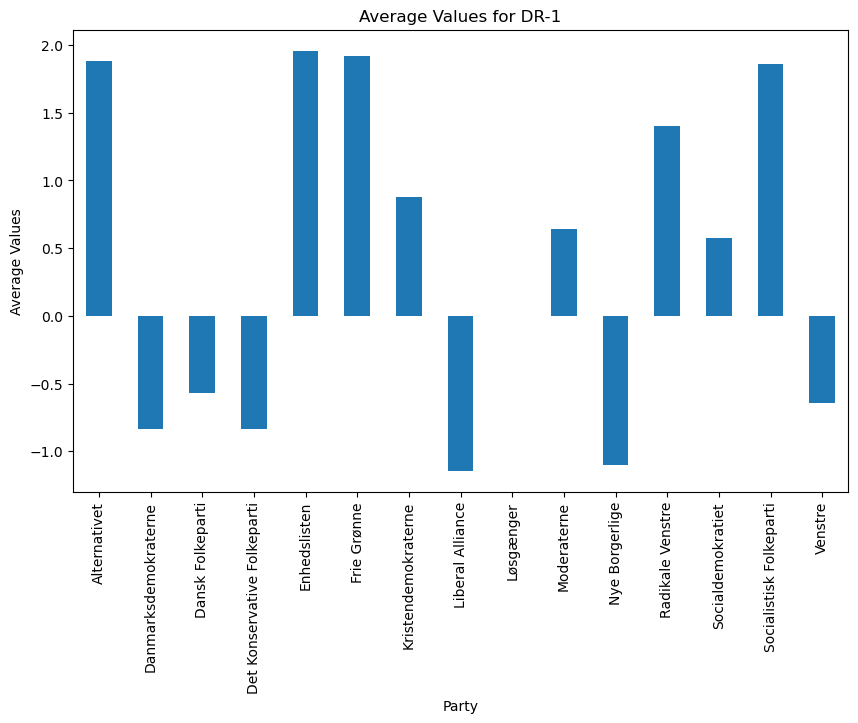

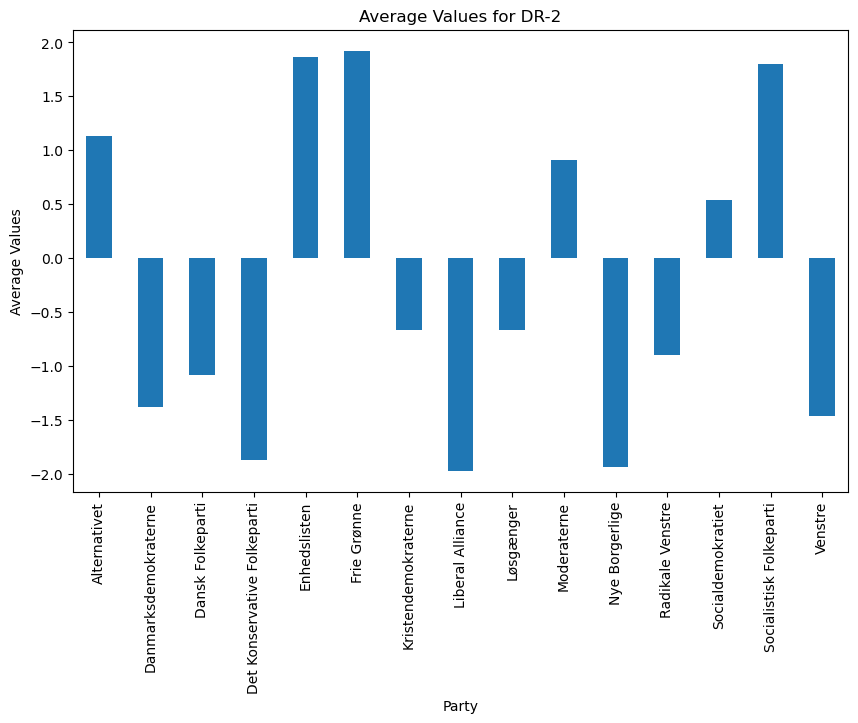

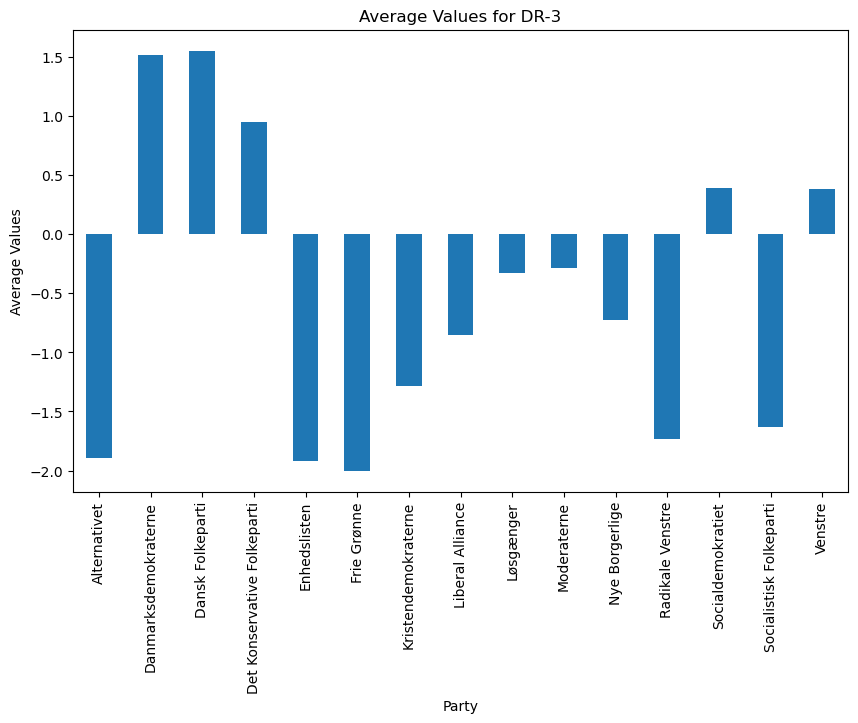

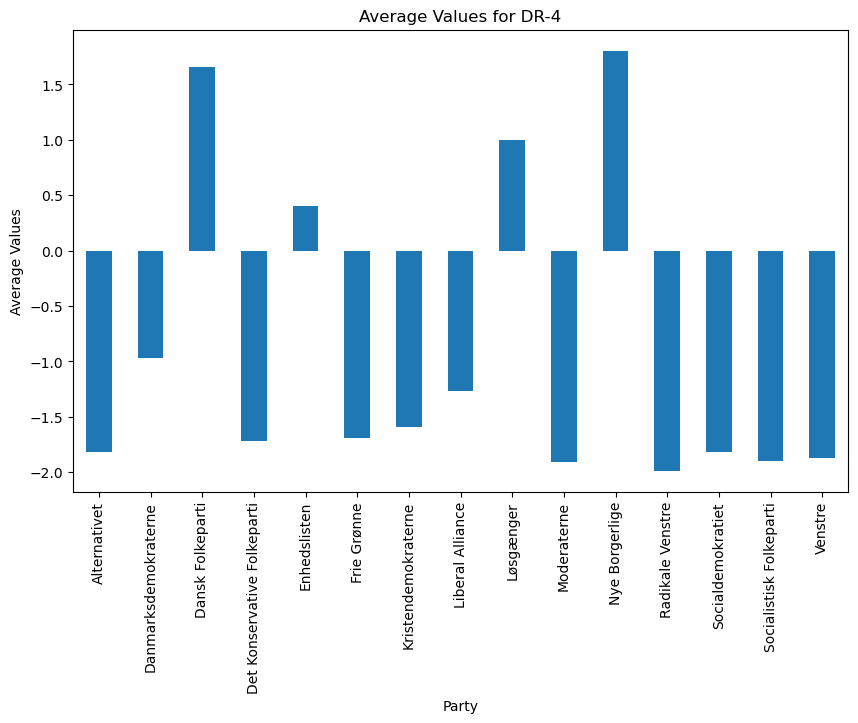

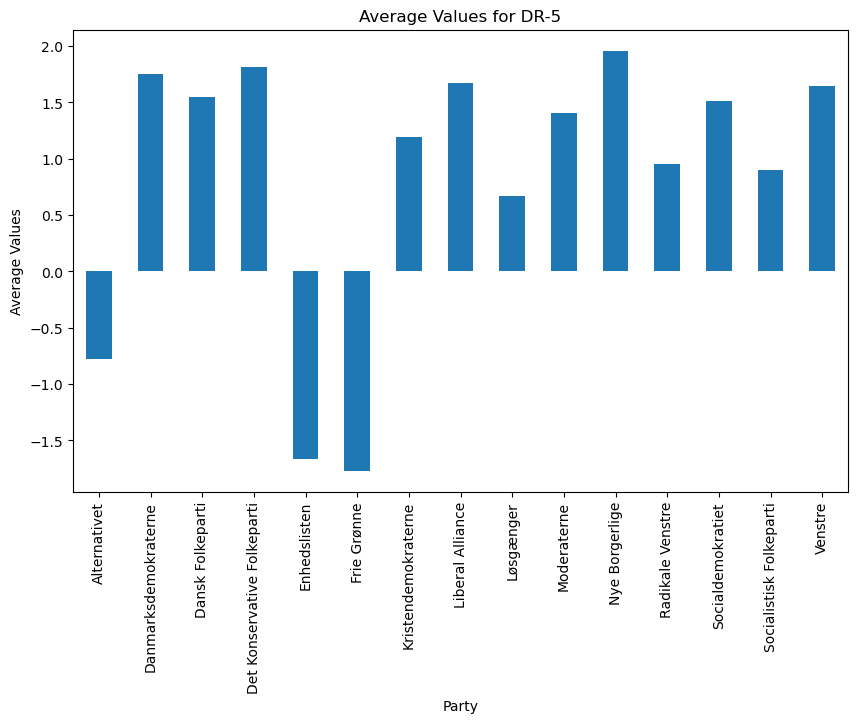

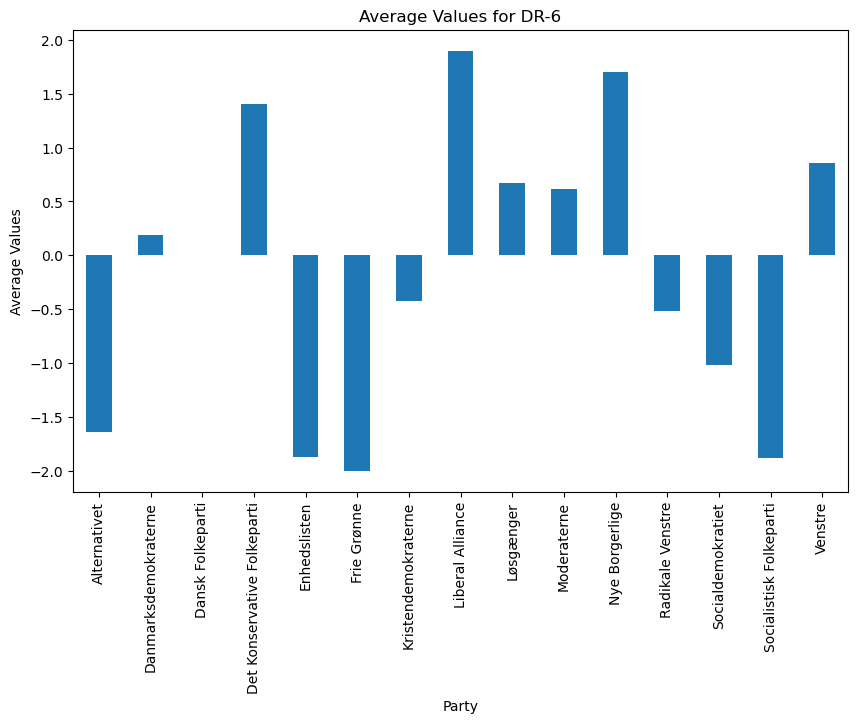

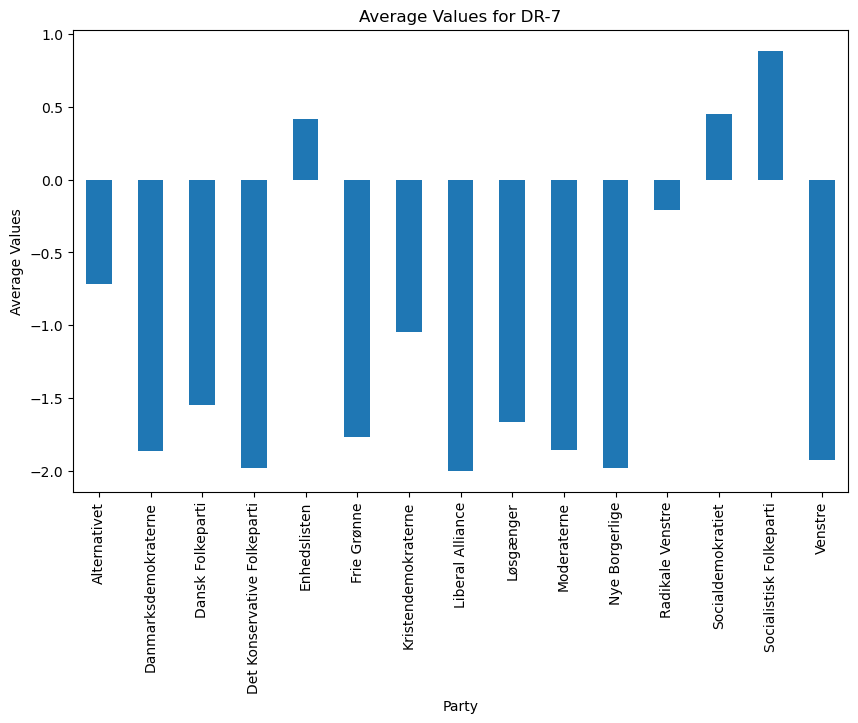

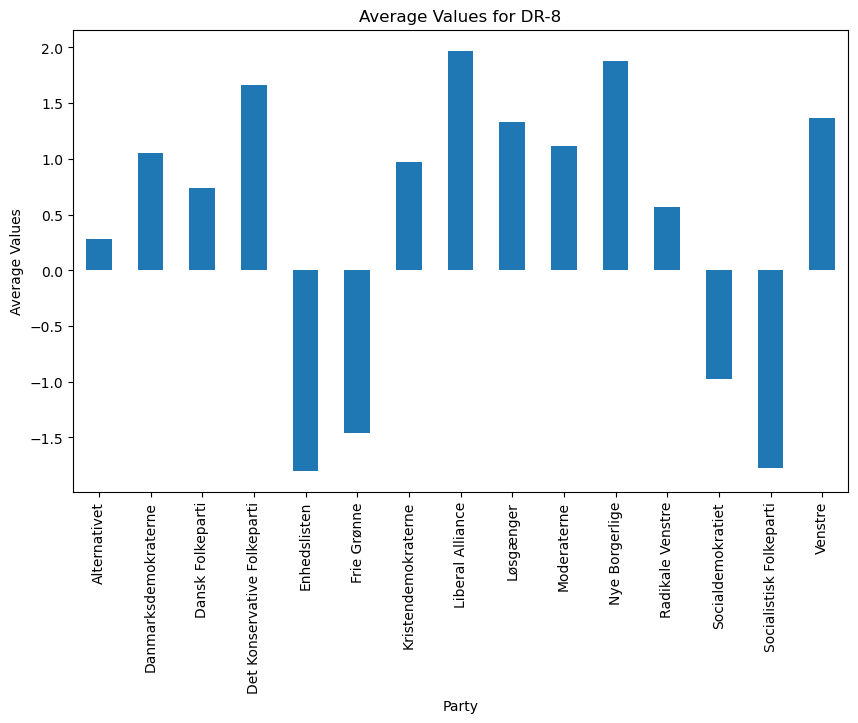

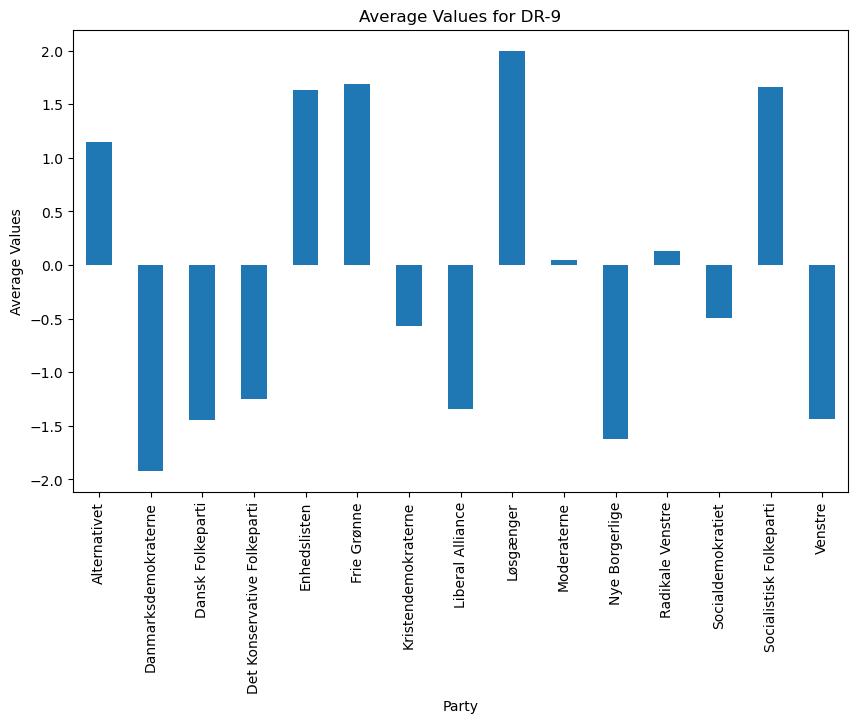

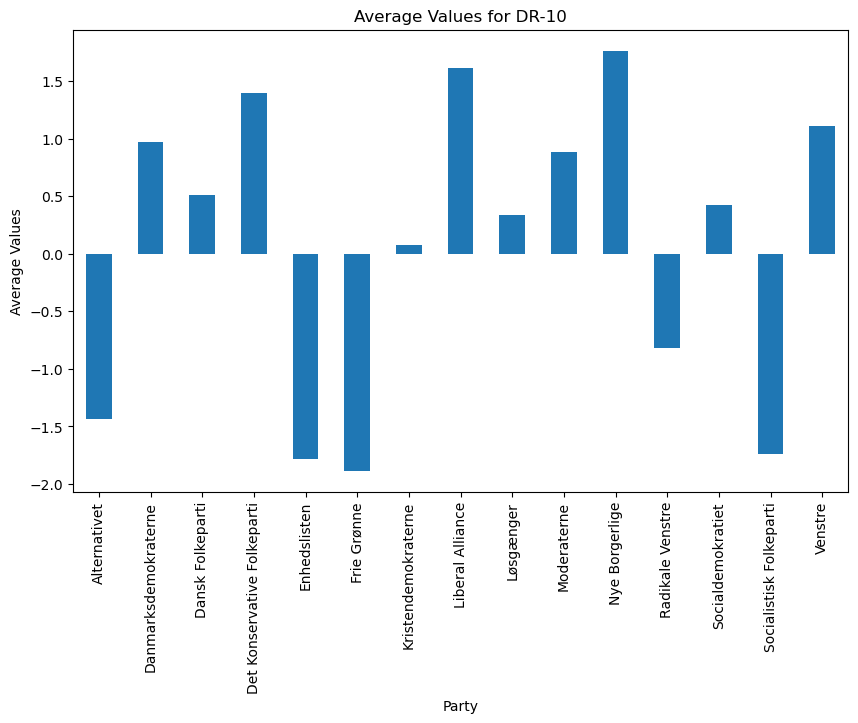

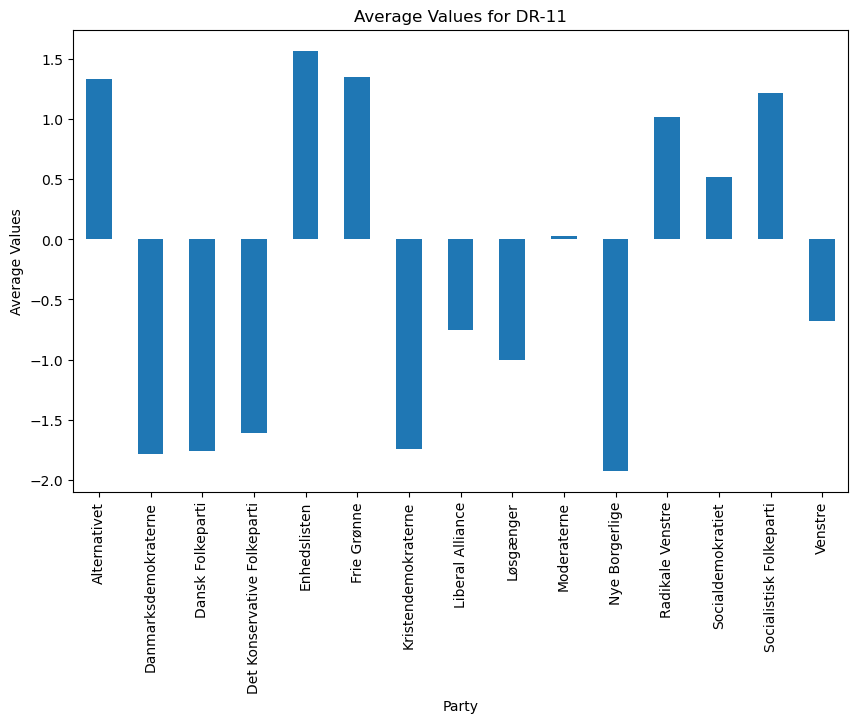

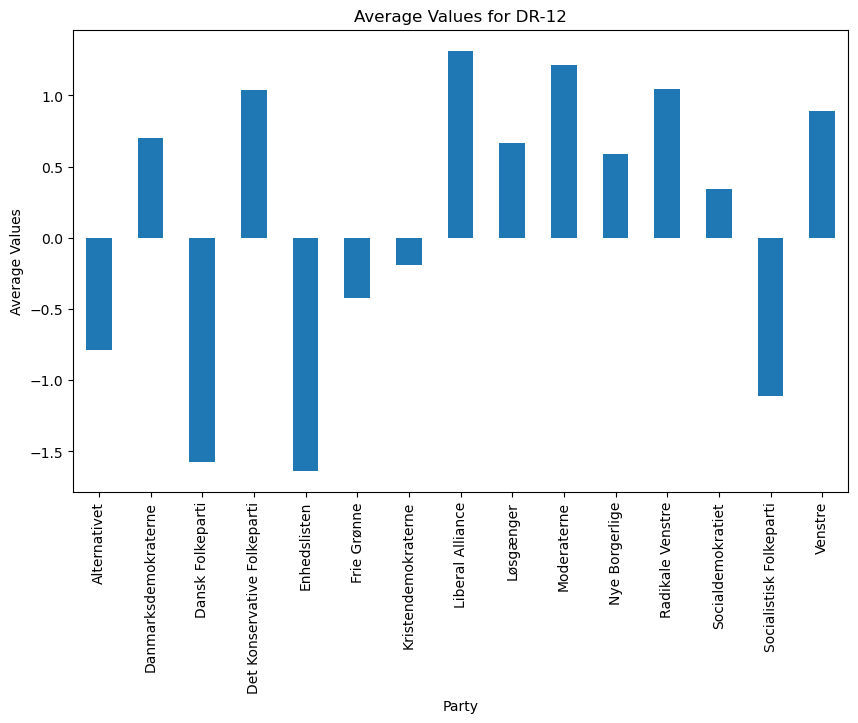

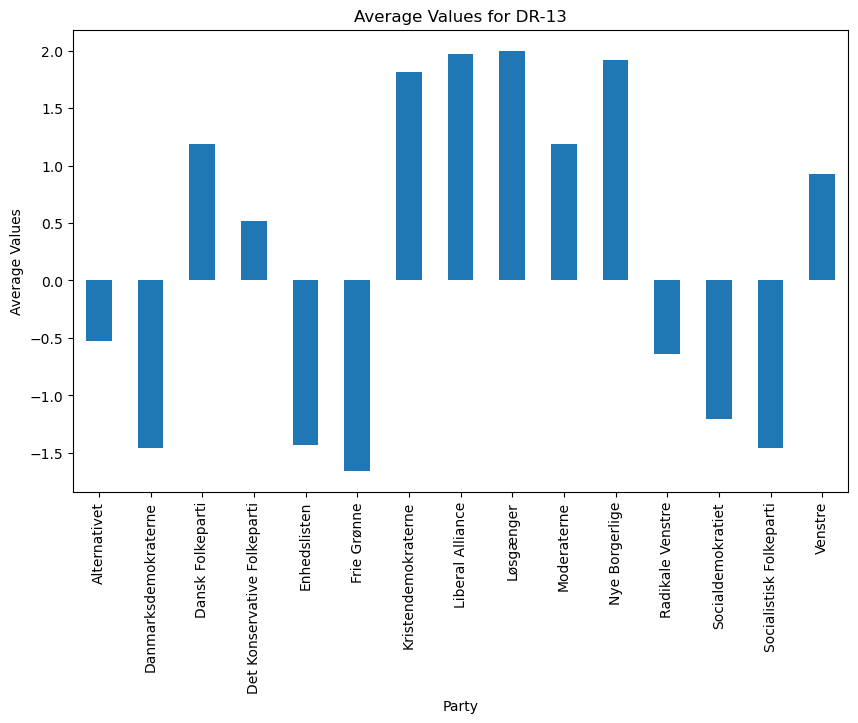

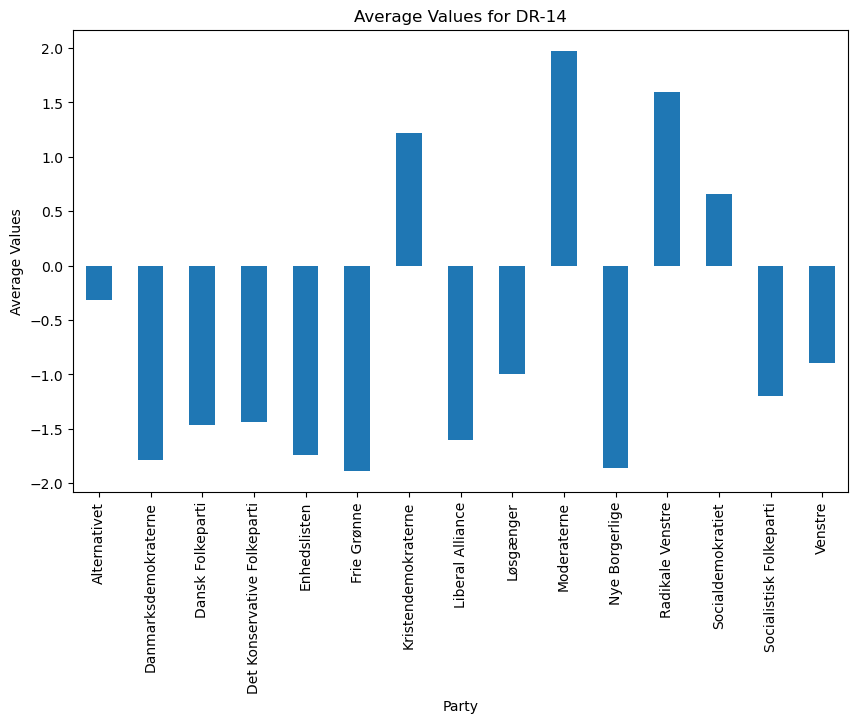

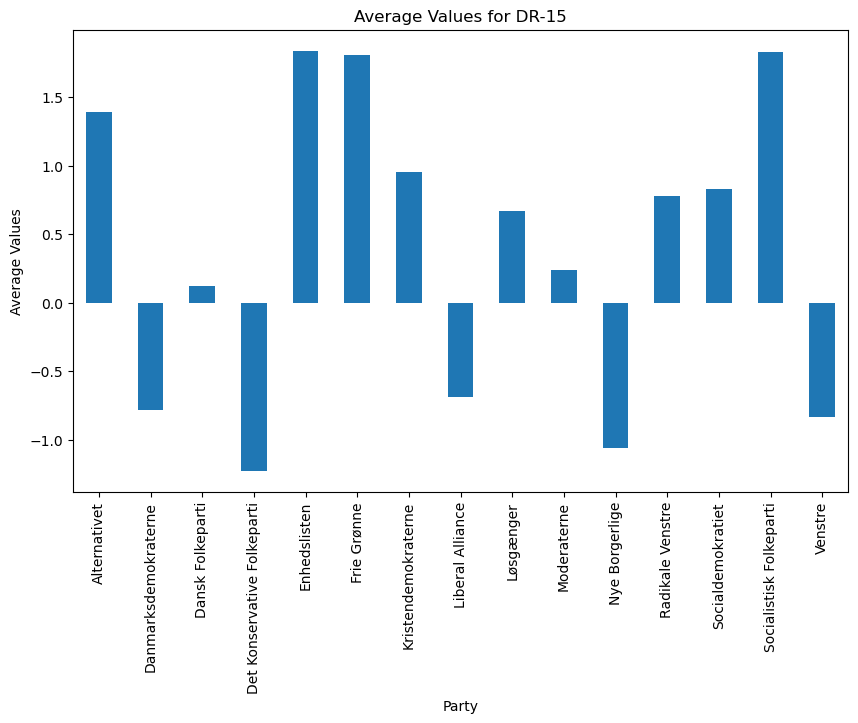

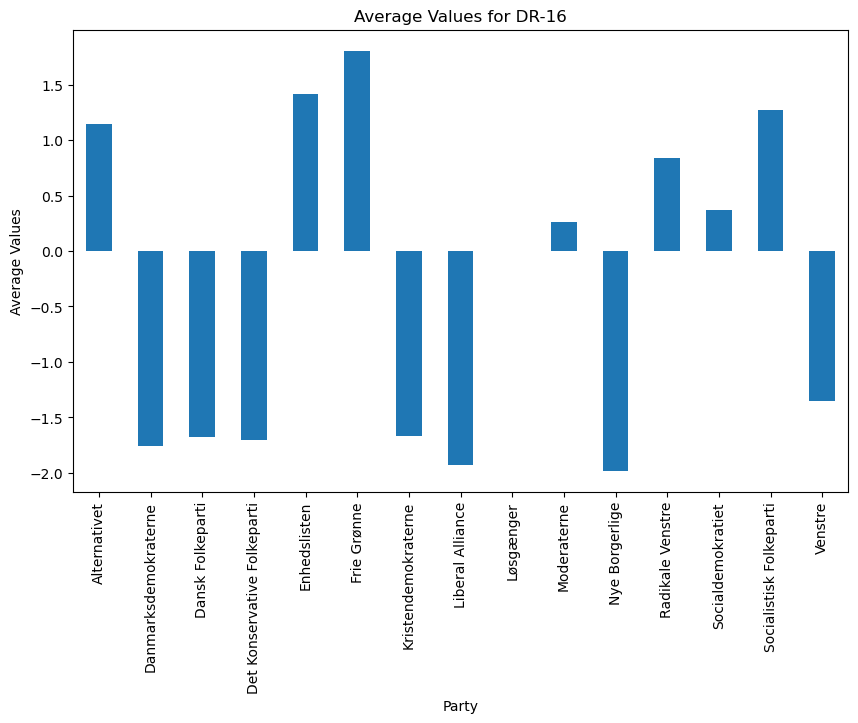

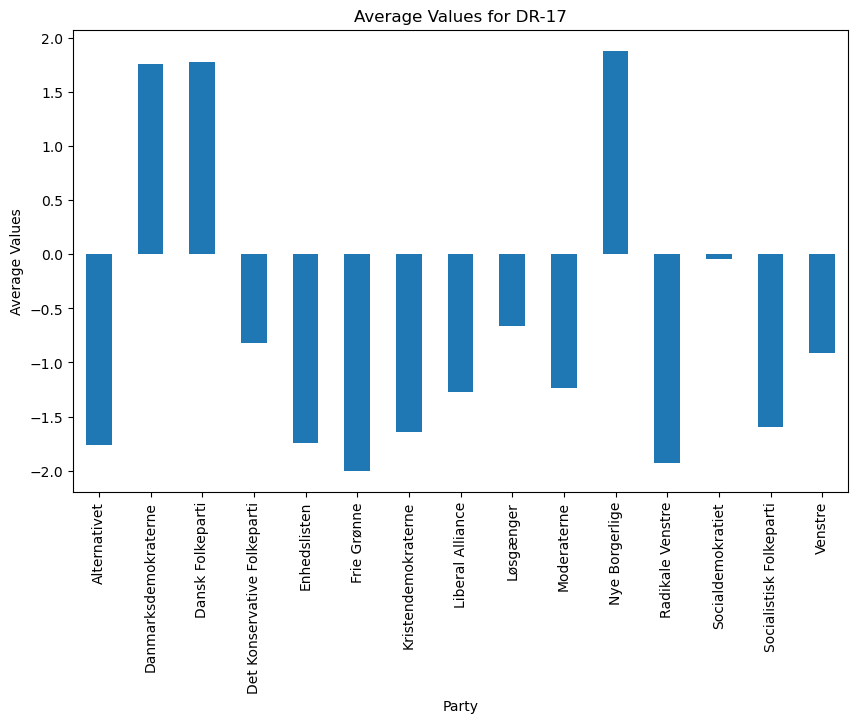

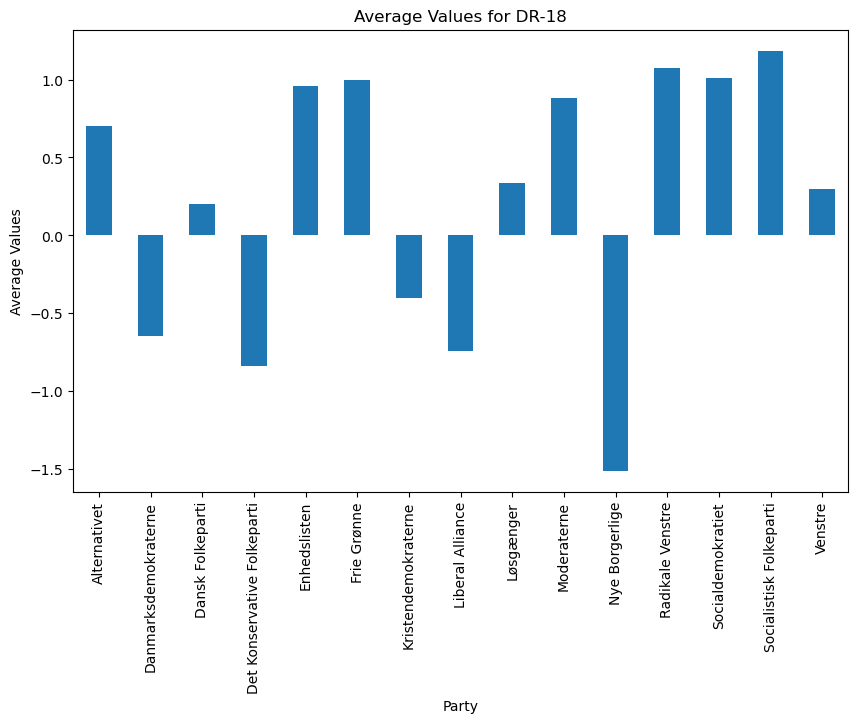

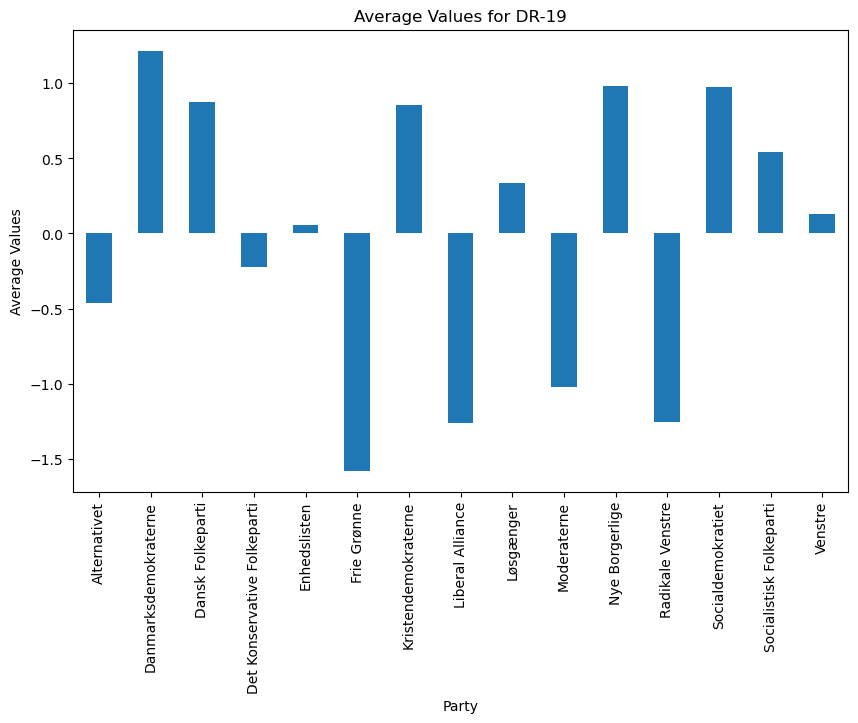

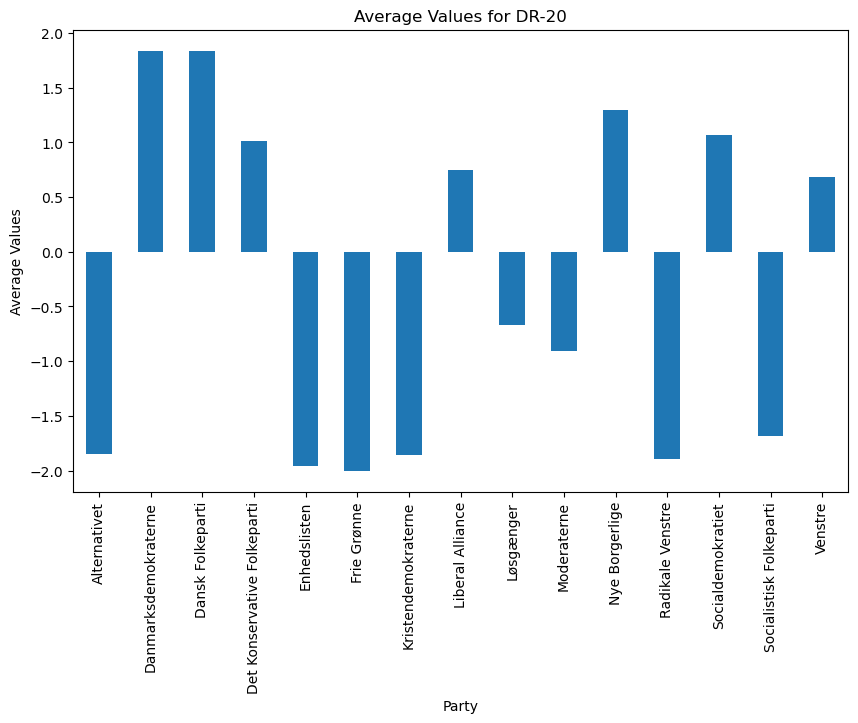

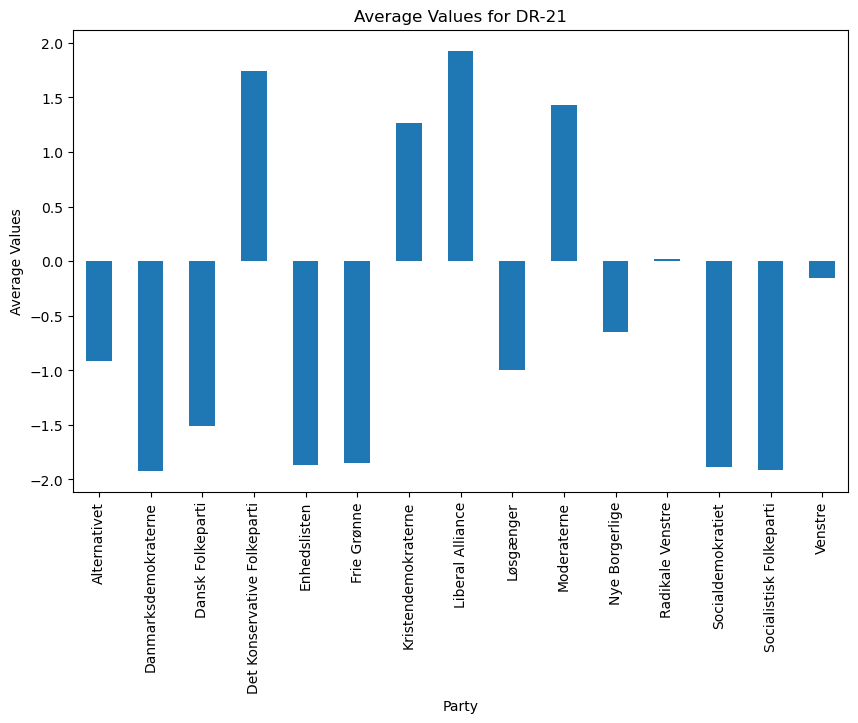

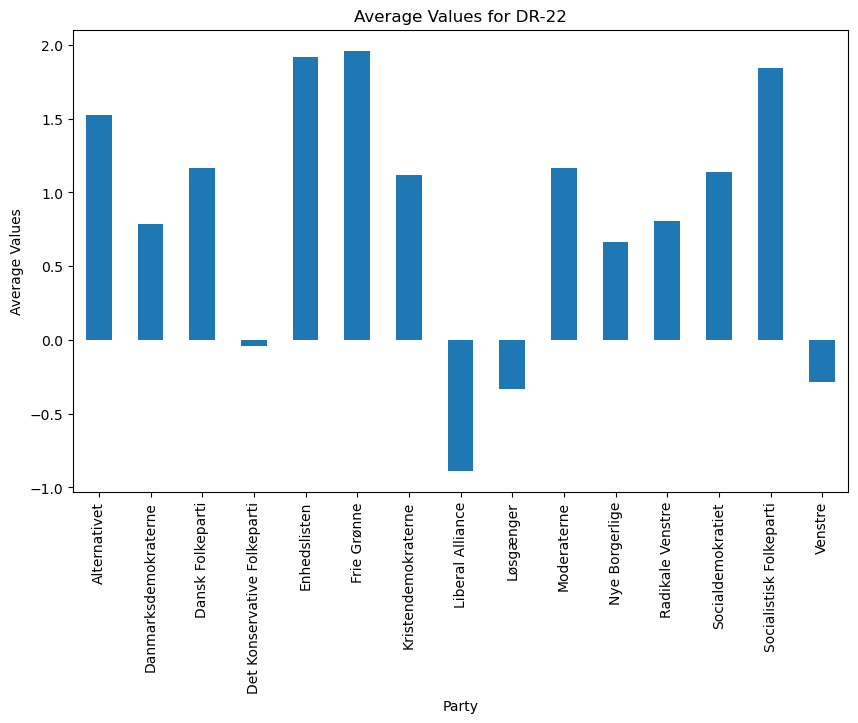

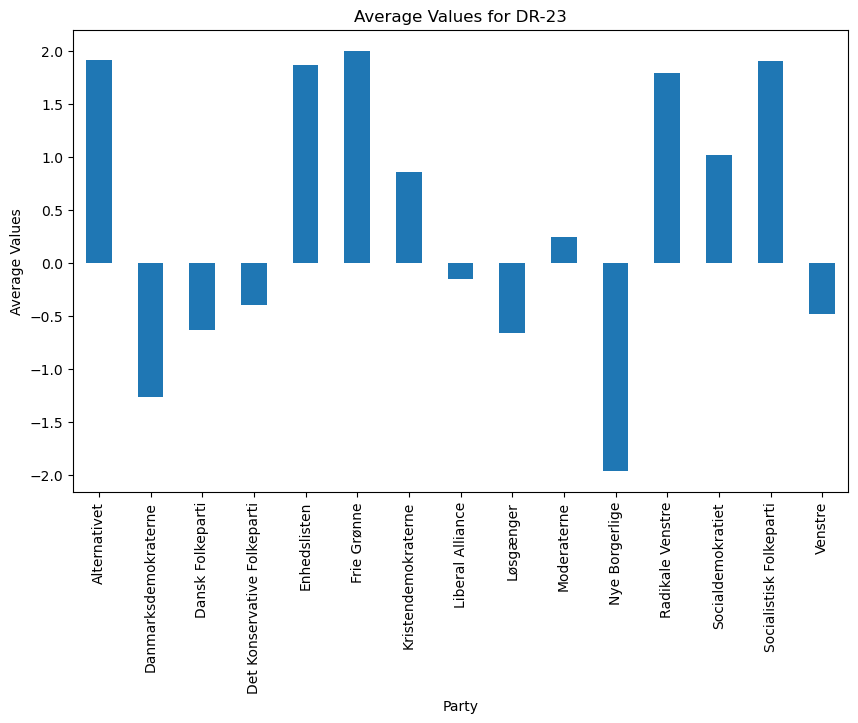

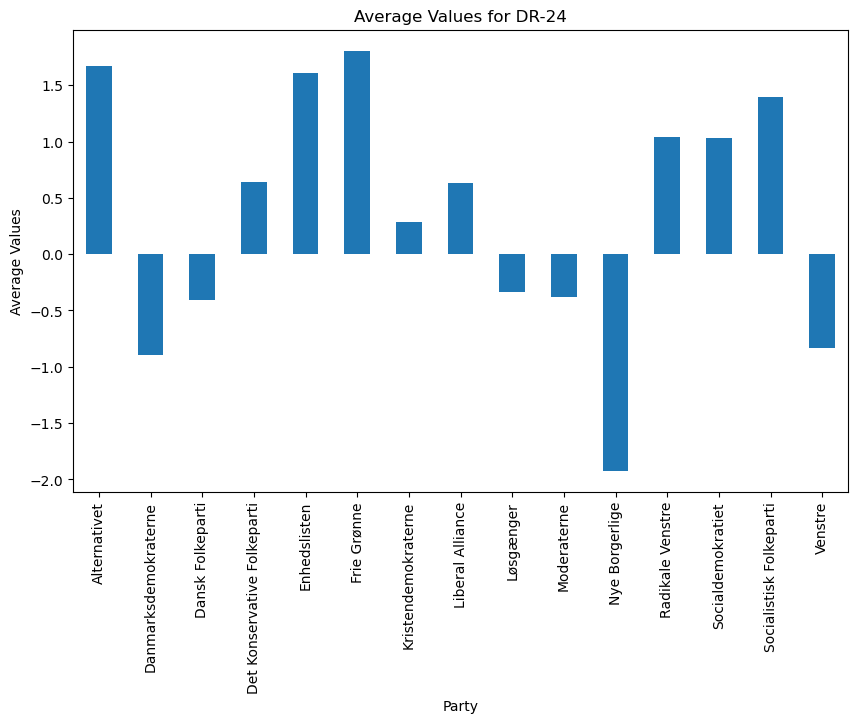

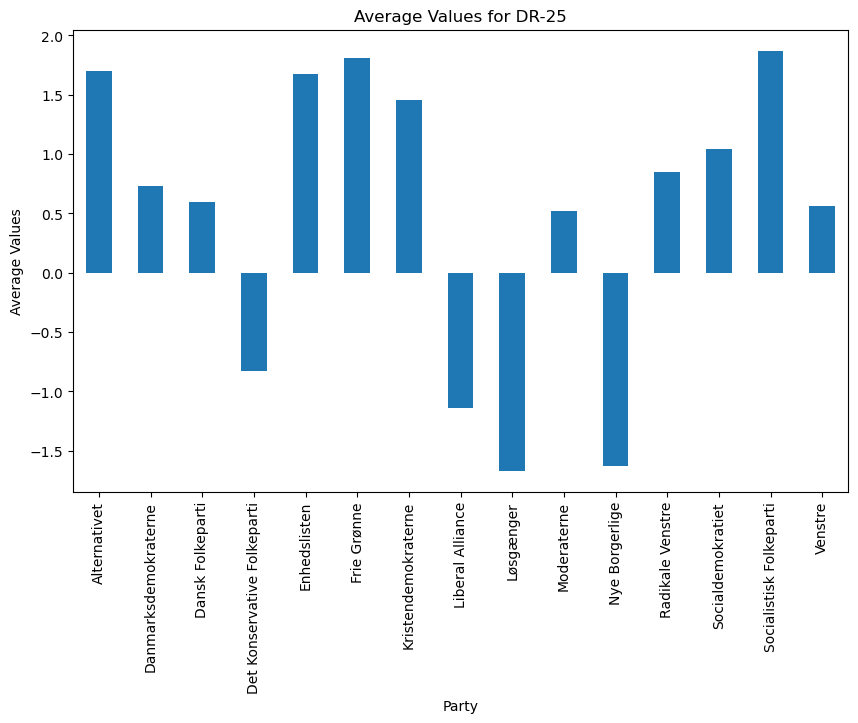

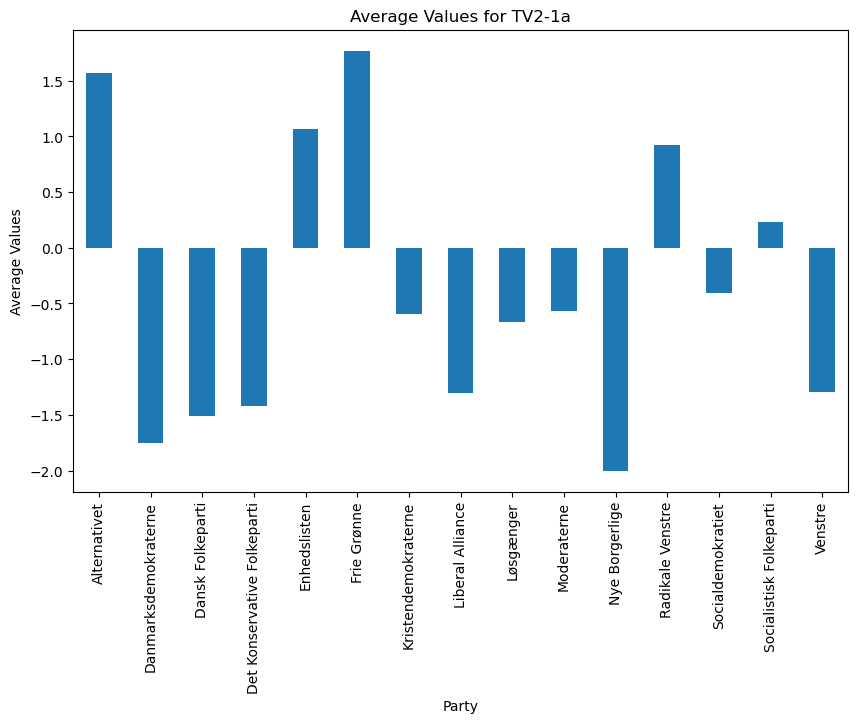

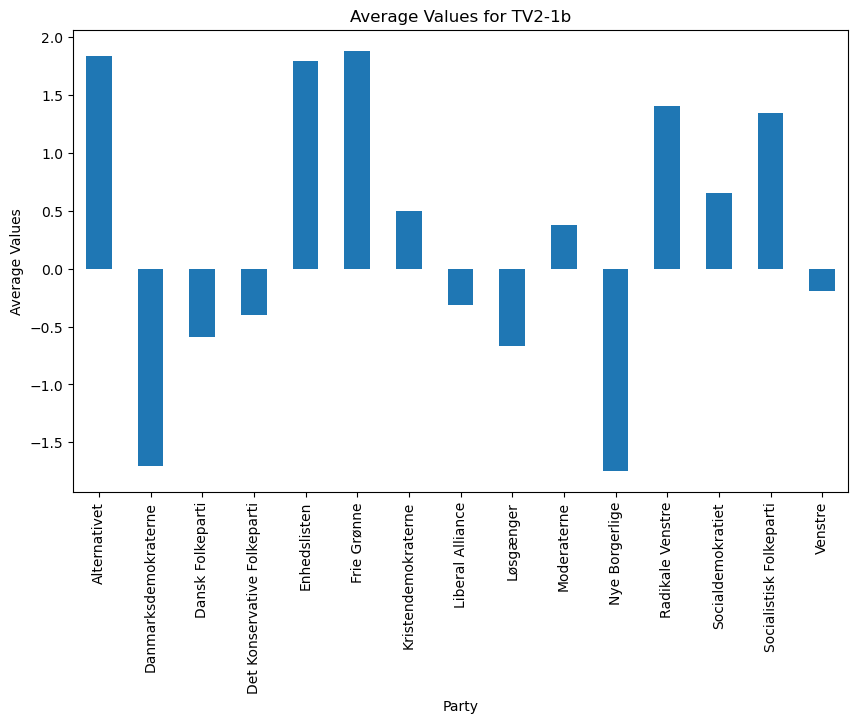

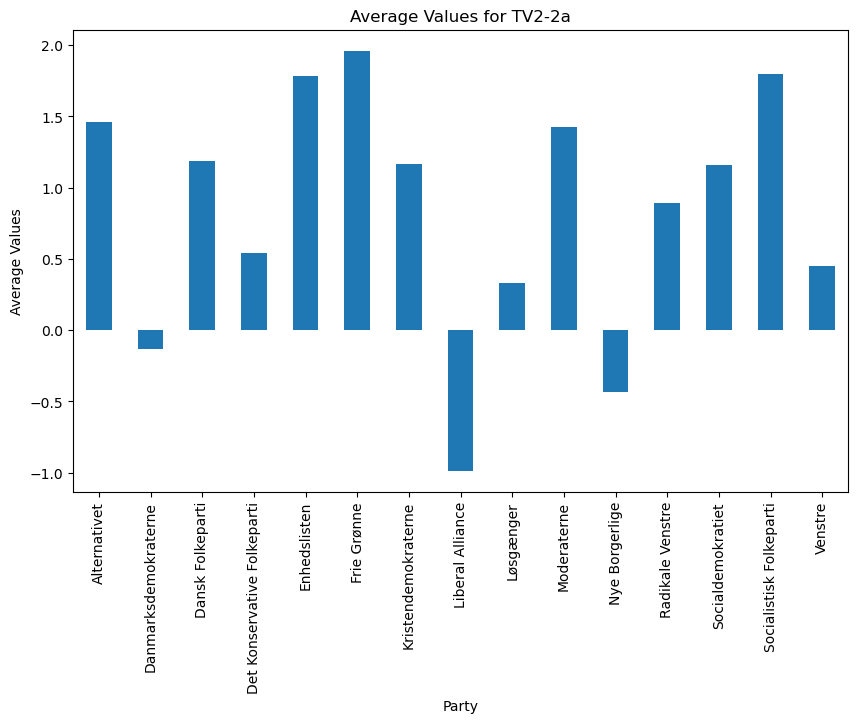

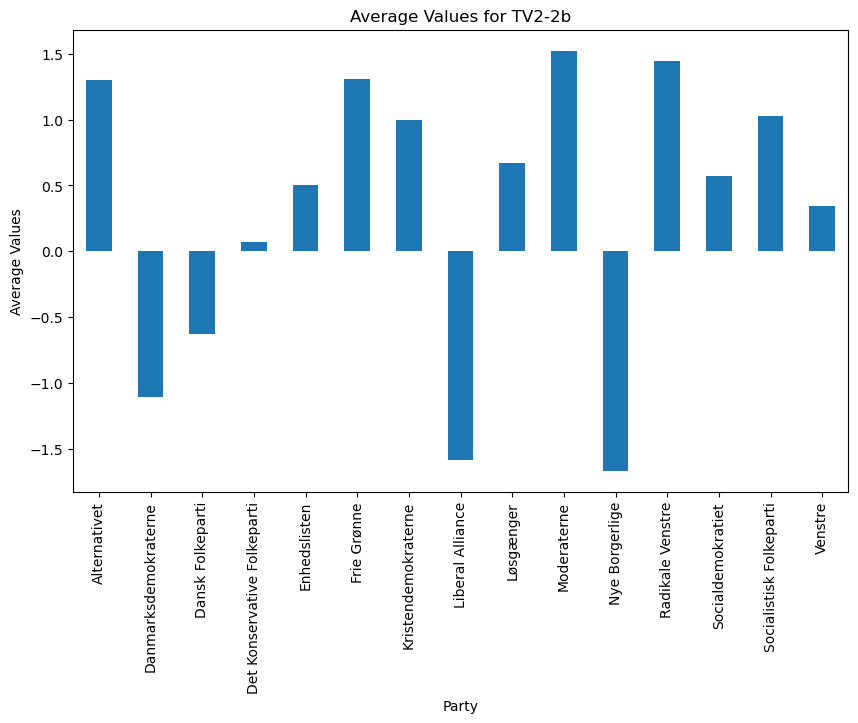

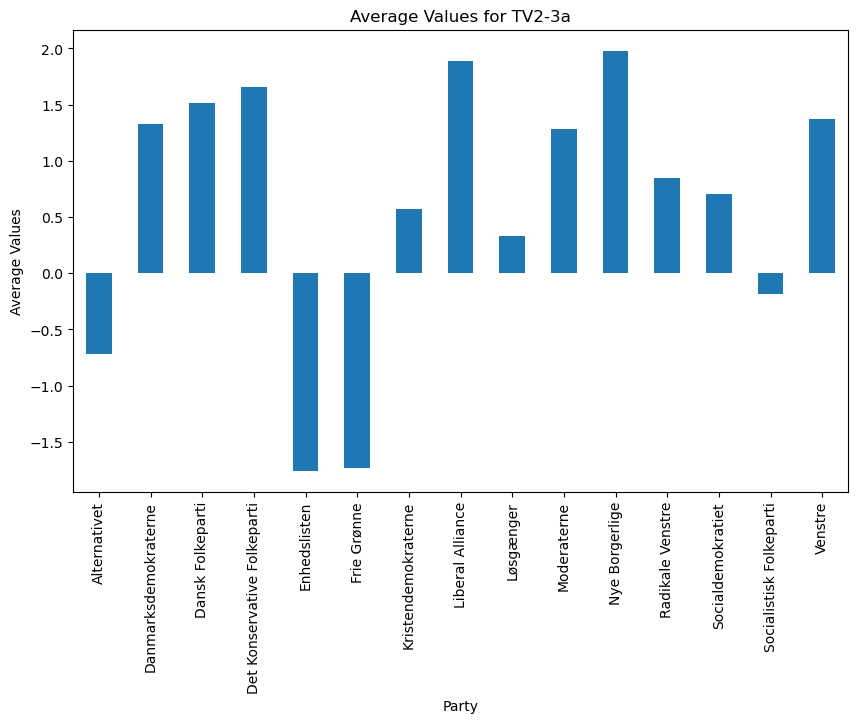

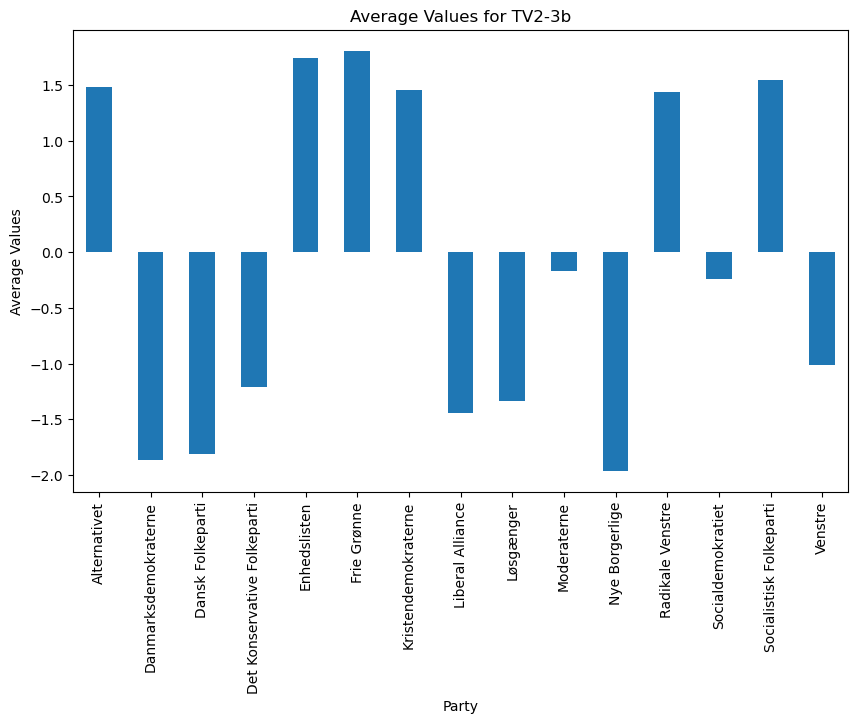

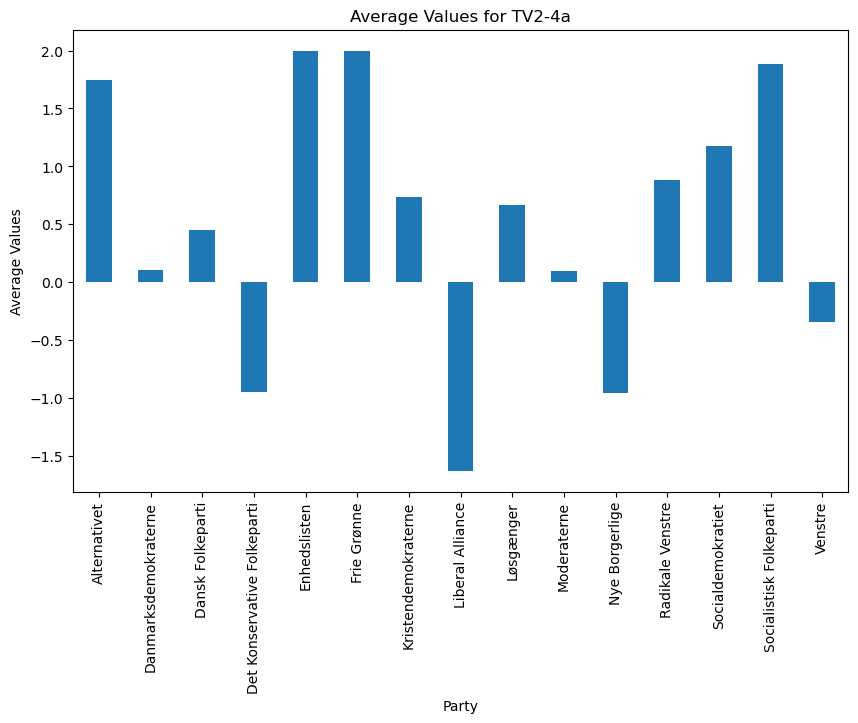

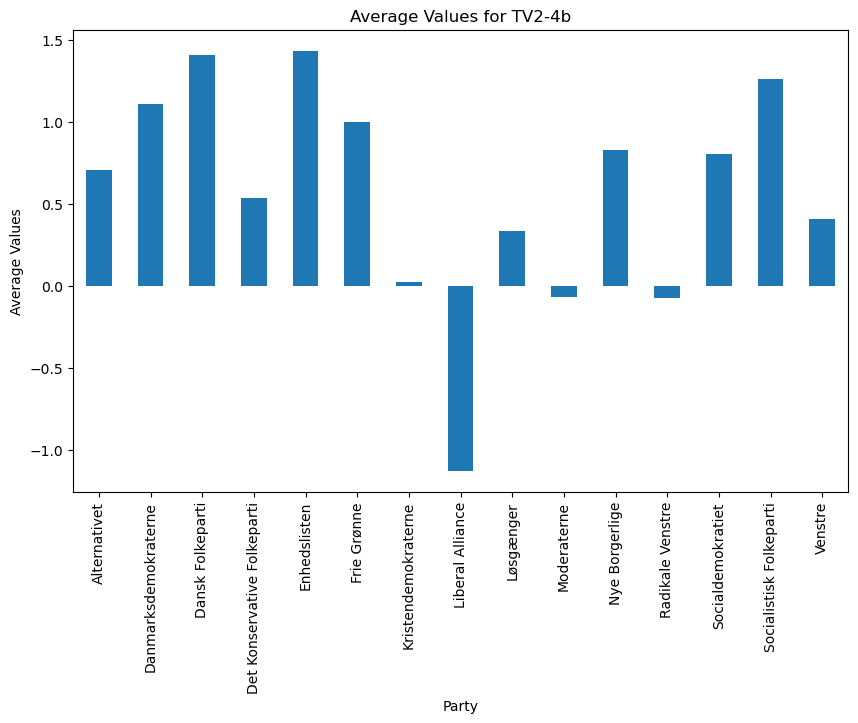

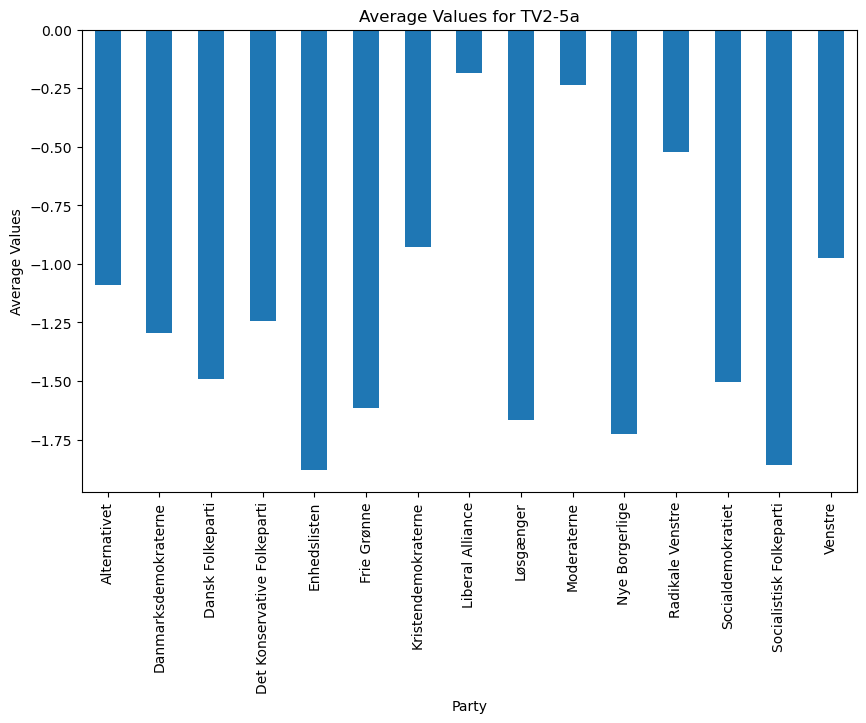

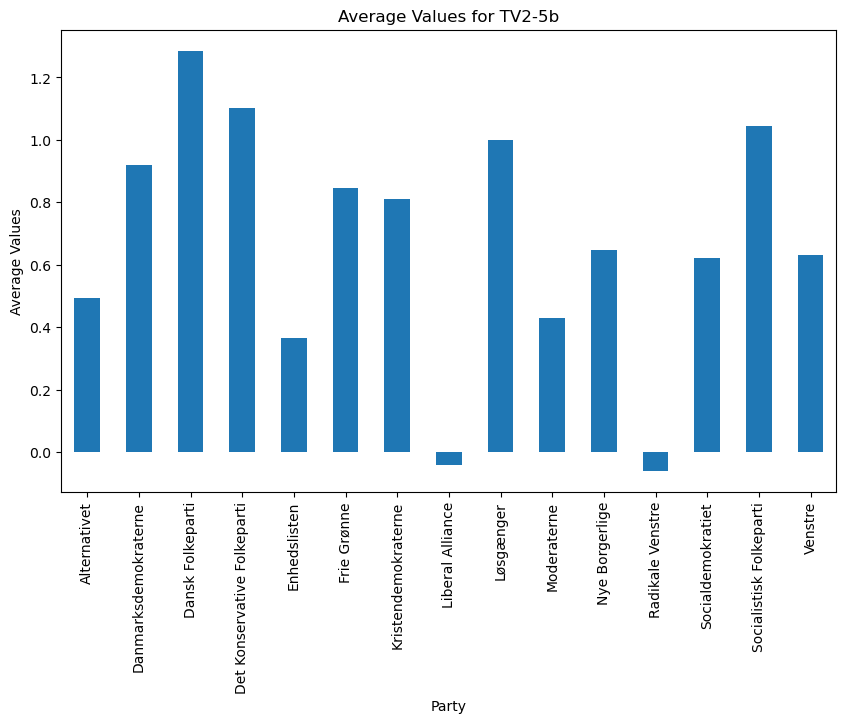

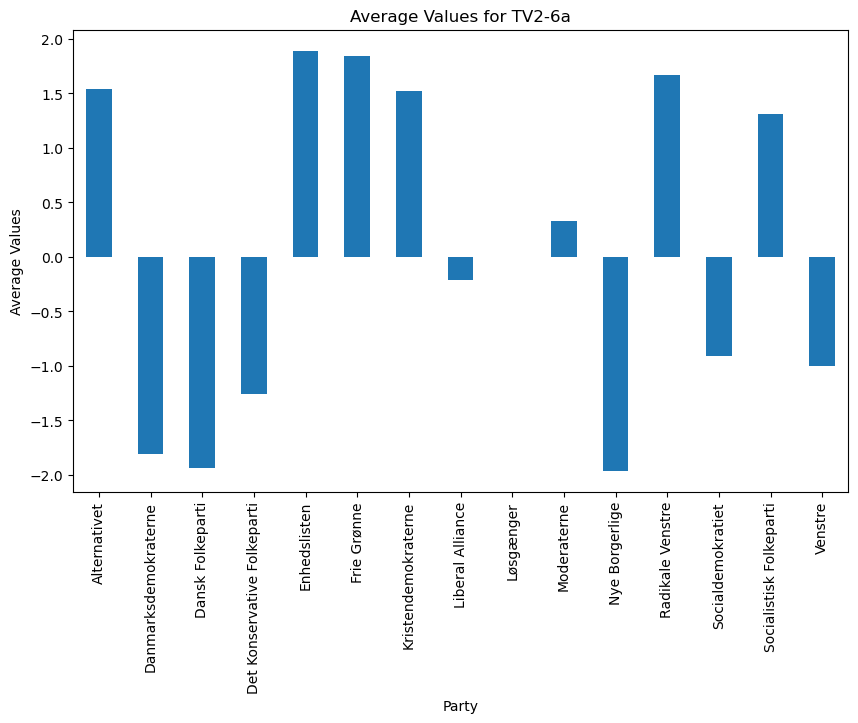

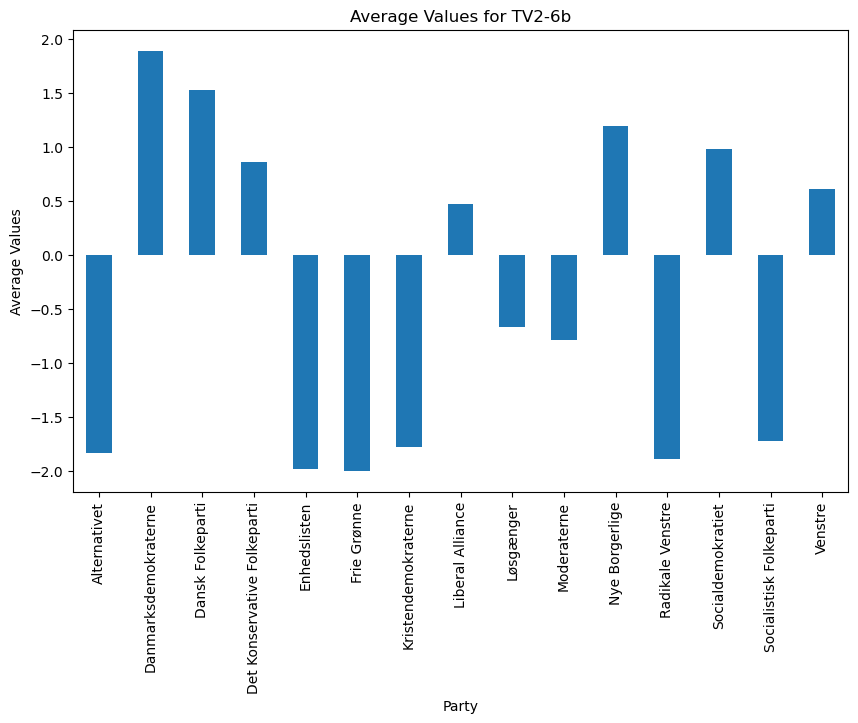

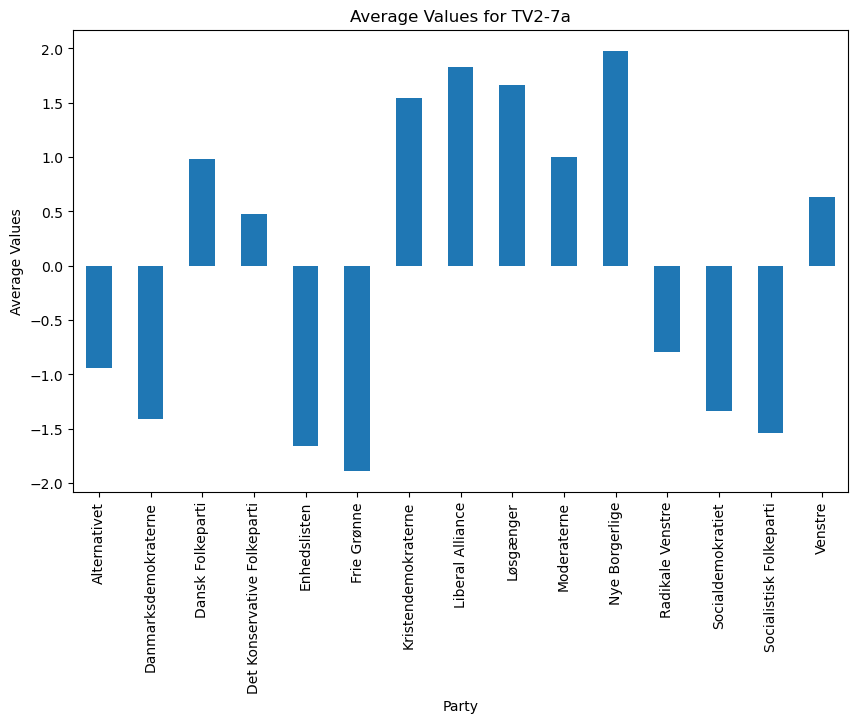

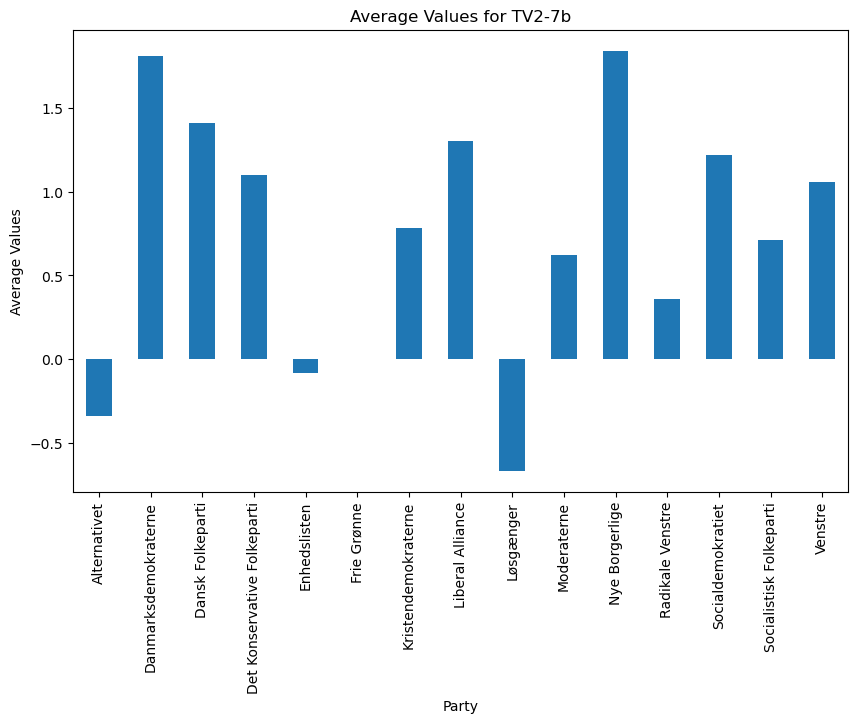

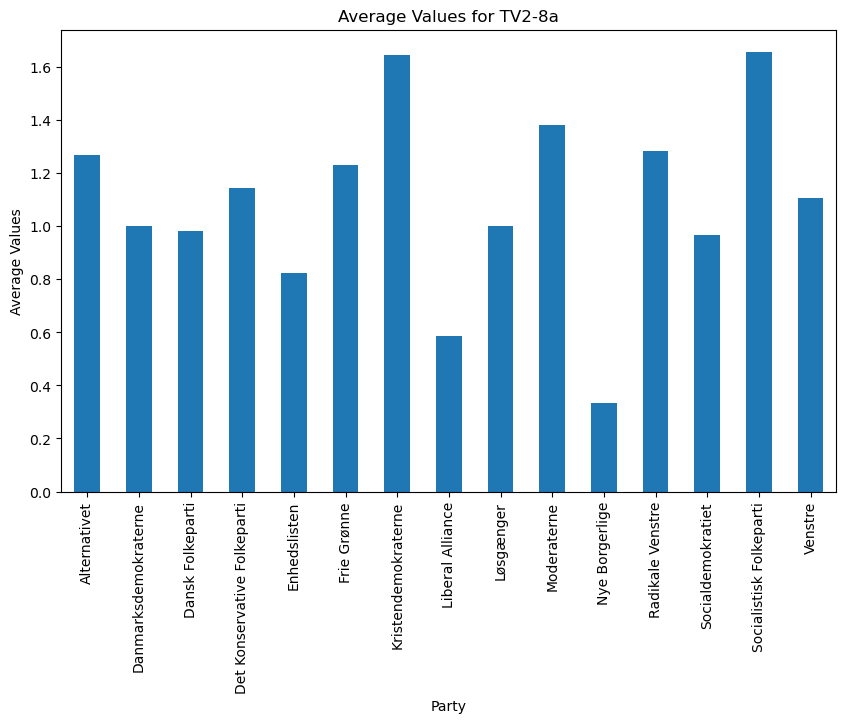

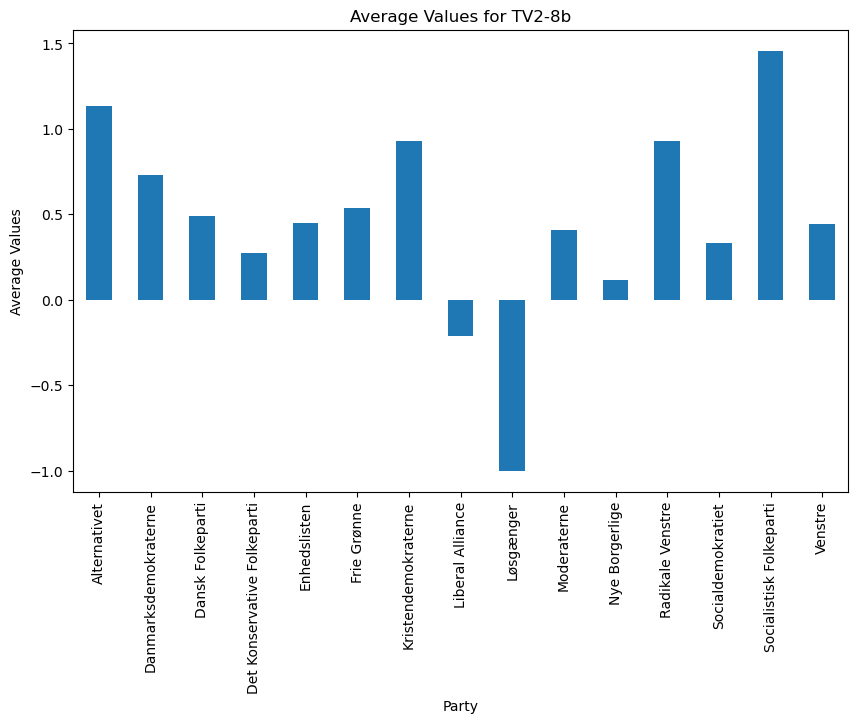

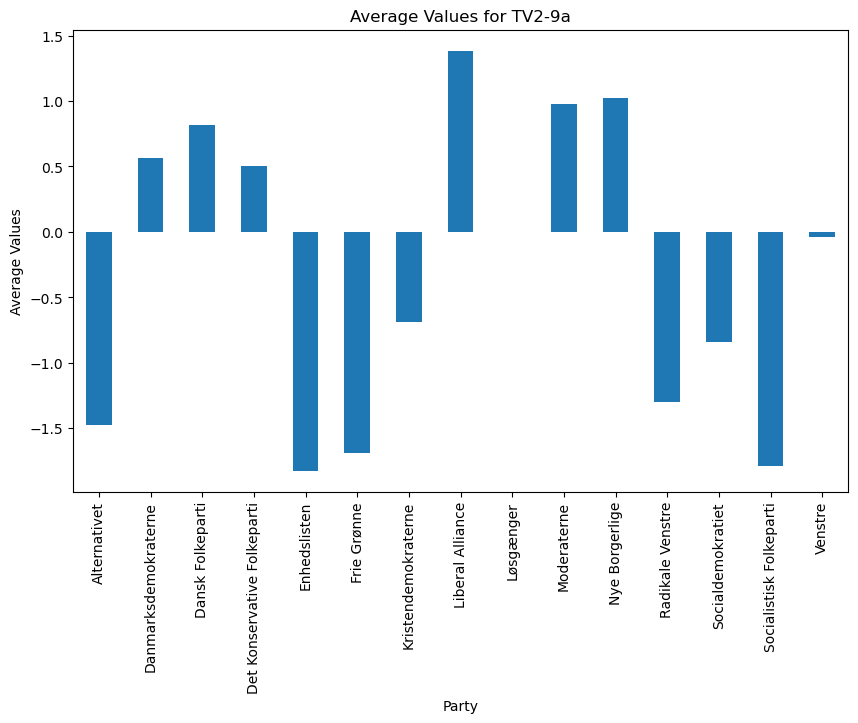

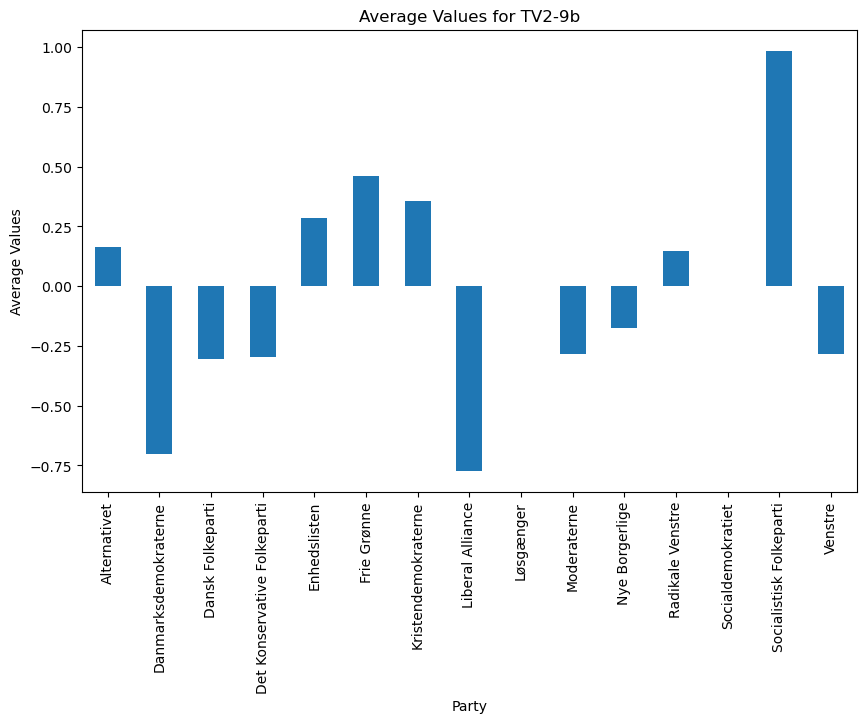

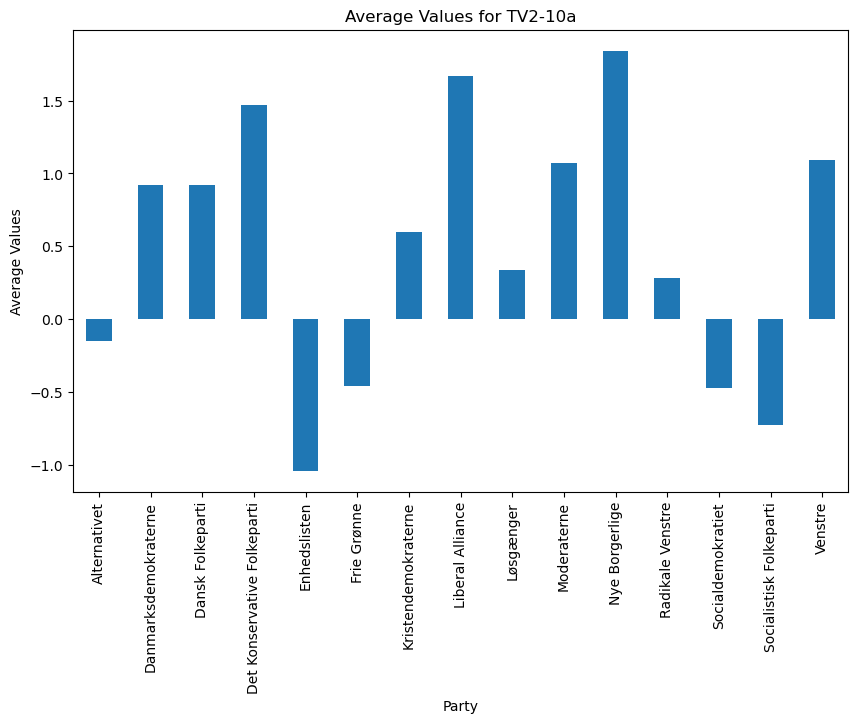

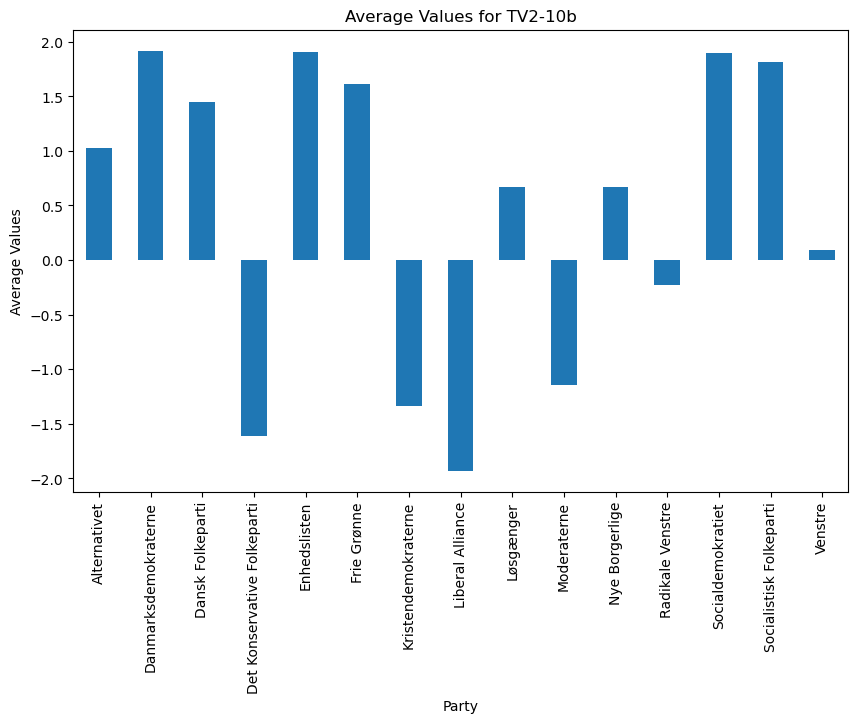

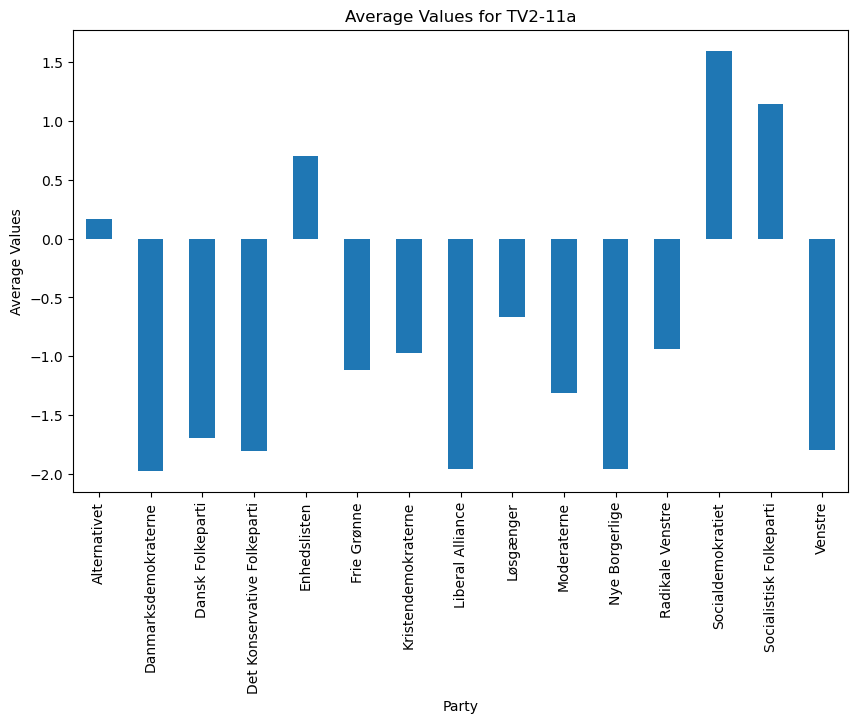

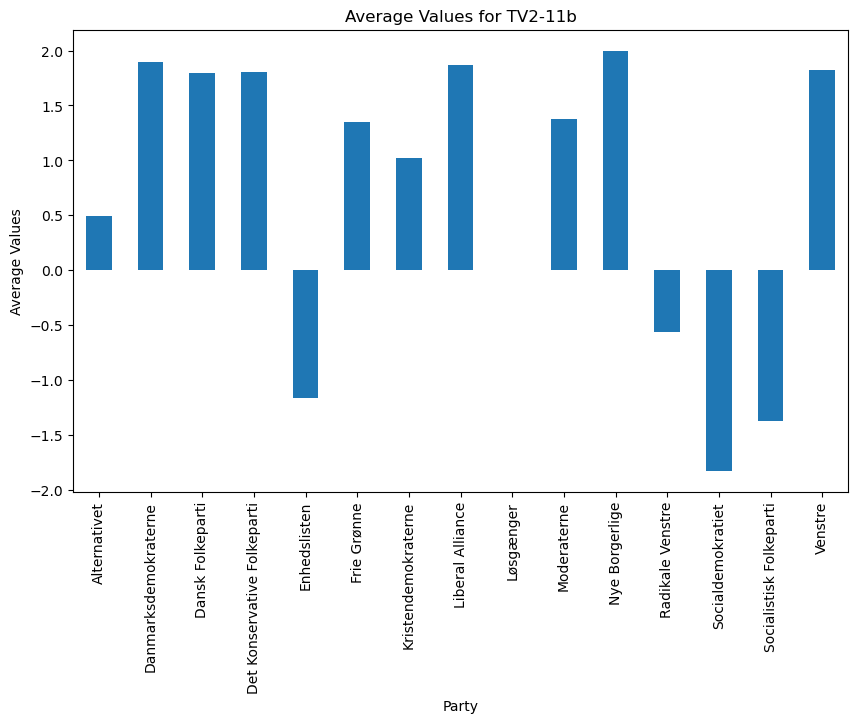

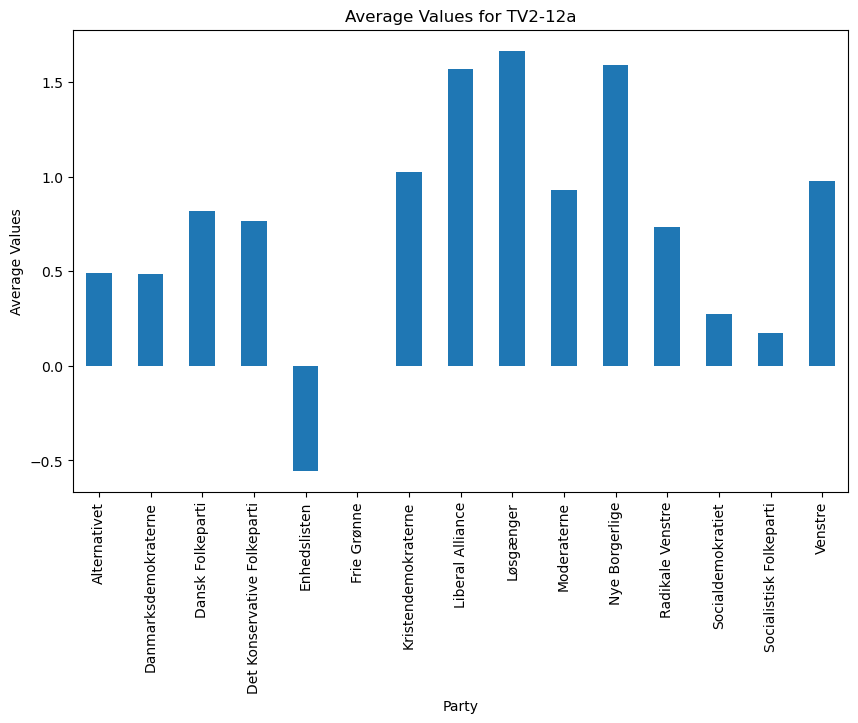

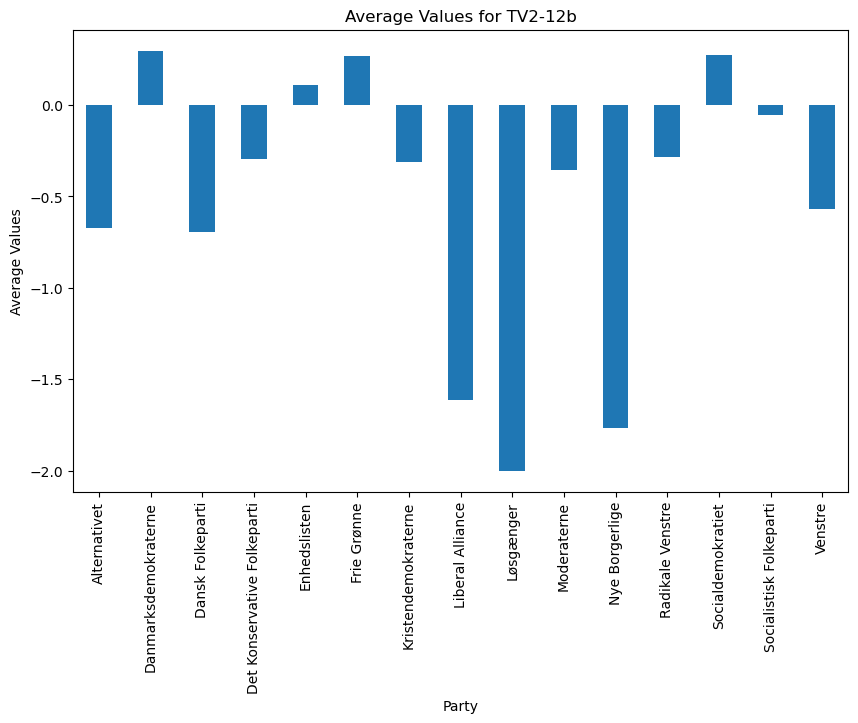

In [115]:
# Looping through each column in the transposed DataFrame
for metric in party_avg.columns:
    # Plotting a bar chart for each metric
    party_avg[metric].plot(kind='bar', title=f'Average Values for {metric}', figsize=(10, 6))
    plt.xlabel('Party')  # Corrected from 'Questions' to 'Party' to reflect what's on the x-axis
    plt.ylabel('Average Values')  # This label describes what the y-axis represents
    plt.show()

### A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**

### An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.